In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchinfo import summary
from tqdm import tqdm
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd


In [ ]:

class ImageDataset(Dataset):
    def __init__(self, txt_file, base_dir, transform=None):
        self.img_labels = []
        self.transform = transform
        self.base_dir = base_dir  # Root directory for images
        
        with open(txt_file, 'r') as f:
            for line in f:
                path, label = line.strip().split()
                full_path = os.path.join(base_dir, path)  # Convert to absolute path
                
                if os.path.exists(full_path):  # Ensure file exists
                    self.img_labels.append((full_path, int(label)))
                else:
                    print(f"Warning: File not found -> {full_path}")  # Debugging output

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path, label = self.img_labels[idx]

        if not os.path.exists(img_path):
            raise FileNotFoundError(f"Image not found: {img_path}")

        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        return image, label


In [16]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to match ResNet input size
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Standard ImageNet normalization
])

# Create dataset and dataloader
train_dataset = ImageDataset(txt_file="train.txt", 
                             base_dir="", 
                             transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = ImageDataset(txt_file="val.txt", 
                             base_dir="", 
                             transform=transform)
val_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

ResNet18

In [17]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.downsample = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )
            
    def forward(self, x):
        shortcut = self.downsample(x)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += shortcut
        out = self.relu(out)
        return out

class ResNet18(nn.Module):
    def __init__(self, num_classes=50):
        super(ResNet18, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(BasicBlock, 64, 2, stride=1)
        self.layer2 = self._make_layer(BasicBlock, 128, 2, stride=2)
        self.layer3 = self._make_layer(BasicBlock, 256, 2, stride=2)
        self.layer4 = self._make_layer(BasicBlock, 512, 2, stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)
        
    def _make_layer(self, block, out_channels, num_blocks, stride):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels
        for _ in range(1, num_blocks):
            layers.append(block(out_channels, out_channels, stride=1))
        return nn.Sequential(*layers)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


In [18]:
model = ResNet18()
summary(model, input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet18                                 [1, 50]                   --
├─Conv2d: 1-1                            [1, 64, 112, 112]         9,408
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         128
├─ReLU: 1-3                              [1, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [1, 64, 56, 56]           --
├─Sequential: 1-5                        [1, 64, 56, 56]           --
│    └─BasicBlock: 2-1                   [1, 64, 56, 56]           --
│    │    └─Sequential: 3-1              [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-2                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-3             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-4                    [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-5                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-6             [1, 64, 56, 56]           128
│

Using device: cuda


Epoch 1/50: 100%|██████████| 1979/1979 [10:00<00:00,  3.30it/s, loss=2.5738, avg_loss=3.2918, accuracy=12.99%]



Training - Epoch 1: Loss: 3.2918, Accuracy: 12.99%
Validation - Epoch 1: Loss: 2.8767, Accuracy: 20.26%

Validation loss improved. Model saved to resnet18_best.pth


Epoch 2/50: 100%|██████████| 1979/1979 [04:19<00:00,  7.64it/s, loss=2.5609, avg_loss=2.6495, accuracy=25.45%]



Training - Epoch 2: Loss: 2.6495, Accuracy: 25.45%
Validation - Epoch 2: Loss: 2.4845, Accuracy: 29.60%

Validation loss improved. Model saved to resnet18_best.pth


Epoch 3/50: 100%|██████████| 1979/1979 [04:18<00:00,  7.65it/s, loss=2.4841, avg_loss=2.2050, accuracy=36.02%]



Training - Epoch 3: Loss: 2.2050, Accuracy: 36.02%
Validation - Epoch 3: Loss: 2.0460, Accuracy: 39.50%

Validation loss improved. Model saved to resnet18_best.pth


Epoch 4/50: 100%|██████████| 1979/1979 [04:18<00:00,  7.66it/s, loss=1.5994, avg_loss=1.8507, accuracy=45.00%]



Training - Epoch 4: Loss: 1.8507, Accuracy: 45.00%
Validation - Epoch 4: Loss: 1.6016, Accuracy: 51.61%

Validation loss improved. Model saved to resnet18_best.pth


Epoch 5/50: 100%|██████████| 1979/1979 [04:14<00:00,  7.77it/s, loss=1.6992, avg_loss=1.5646, accuracy=52.59%]



Training - Epoch 5: Loss: 1.5646, Accuracy: 52.59%
Validation - Epoch 5: Loss: 1.3027, Accuracy: 59.43%

Validation loss improved. Model saved to resnet18_best.pth


Epoch 6/50: 100%|██████████| 1979/1979 [04:19<00:00,  7.63it/s, loss=0.8420, avg_loss=1.3222, accuracy=58.99%]



Training - Epoch 6: Loss: 1.3222, Accuracy: 58.99%
Validation - Epoch 6: Loss: 1.0866, Accuracy: 65.88%

Validation loss improved. Model saved to resnet18_best.pth


Epoch 7/50: 100%|██████████| 1979/1979 [04:19<00:00,  7.62it/s, loss=0.8739, avg_loss=1.0932, accuracy=65.22%]



Training - Epoch 7: Loss: 1.0932, Accuracy: 65.22%
Validation - Epoch 7: Loss: 0.7723, Accuracy: 75.31%

Validation loss improved. Model saved to resnet18_best.pth


Epoch 8/50: 100%|██████████| 1979/1979 [04:19<00:00,  7.63it/s, loss=1.0723, avg_loss=0.8520, accuracy=72.15%]



Training - Epoch 8: Loss: 0.8520, Accuracy: 72.15%
Validation - Epoch 8: Loss: 0.6133, Accuracy: 79.72%

Validation loss improved. Model saved to resnet18_best.pth


Epoch 9/50: 100%|██████████| 1979/1979 [04:19<00:00,  7.62it/s, loss=0.6882, avg_loss=0.6343, accuracy=78.78%]



Training - Epoch 9: Loss: 0.6343, Accuracy: 78.78%
Validation - Epoch 9: Loss: 0.4000, Accuracy: 87.27%

Validation loss improved. Model saved to resnet18_best.pth


Epoch 10/50: 100%|██████████| 1979/1979 [04:19<00:00,  7.61it/s, loss=0.3288, avg_loss=0.4469, accuracy=84.98%]



Training - Epoch 10: Loss: 0.4469, Accuracy: 84.98%
Validation - Epoch 10: Loss: 0.2723, Accuracy: 91.13%

Validation loss improved. Model saved to resnet18_best.pth


Epoch 11/50: 100%|██████████| 1979/1979 [04:22<00:00,  7.53it/s, loss=0.2421, avg_loss=0.3321, accuracy=88.91%]



Training - Epoch 11: Loss: 0.3321, Accuracy: 88.91%
Validation - Epoch 11: Loss: 0.1794, Accuracy: 94.52%

Validation loss improved. Model saved to resnet18_best.pth


Epoch 12/50: 100%|██████████| 1979/1979 [04:20<00:00,  7.61it/s, loss=0.1303, avg_loss=0.2580, accuracy=91.63%]



Training - Epoch 12: Loss: 0.2580, Accuracy: 91.63%
Validation - Epoch 12: Loss: 0.1940, Accuracy: 93.84%

No improvement for 1 epoch(s).


Epoch 13/50: 100%|██████████| 1979/1979 [04:19<00:00,  7.63it/s, loss=0.1382, avg_loss=0.2173, accuracy=93.12%]



Training - Epoch 13: Loss: 0.2173, Accuracy: 93.12%
Validation - Epoch 13: Loss: 0.1369, Accuracy: 95.89%

Validation loss improved. Model saved to resnet18_best.pth


Epoch 14/50: 100%|██████████| 1979/1979 [04:18<00:00,  7.66it/s, loss=0.2152, avg_loss=0.1892, accuracy=94.11%]



Training - Epoch 14: Loss: 0.1892, Accuracy: 94.11%
Validation - Epoch 14: Loss: 0.1346, Accuracy: 96.15%

Validation loss improved. Model saved to resnet18_best.pth


Epoch 15/50: 100%|██████████| 1979/1979 [04:18<00:00,  7.65it/s, loss=0.1102, avg_loss=0.1739, accuracy=94.74%]



Training - Epoch 15: Loss: 0.1739, Accuracy: 94.74%
Validation - Epoch 15: Loss: 0.0957, Accuracy: 97.21%

Validation loss improved. Model saved to resnet18_best.pth


Epoch 16/50: 100%|██████████| 1979/1979 [04:19<00:00,  7.63it/s, loss=0.3050, avg_loss=0.1544, accuracy=95.31%]



Training - Epoch 16: Loss: 0.1544, Accuracy: 95.31%
Validation - Epoch 16: Loss: 0.0981, Accuracy: 97.23%

No improvement for 1 epoch(s).


Epoch 17/50: 100%|██████████| 1979/1979 [04:18<00:00,  7.66it/s, loss=0.2915, avg_loss=0.1451, accuracy=95.69%]



Training - Epoch 17: Loss: 0.1451, Accuracy: 95.69%
Validation - Epoch 17: Loss: 0.0821, Accuracy: 97.61%

Validation loss improved. Model saved to resnet18_best.pth


Epoch 18/50: 100%|██████████| 1979/1979 [04:17<00:00,  7.68it/s, loss=0.0425, avg_loss=0.1321, accuracy=96.01%]



Training - Epoch 18: Loss: 0.1321, Accuracy: 96.01%
Validation - Epoch 18: Loss: 0.0818, Accuracy: 97.62%

Validation loss improved. Model saved to resnet18_best.pth


Epoch 19/50: 100%|██████████| 1979/1979 [04:18<00:00,  7.67it/s, loss=0.0386, avg_loss=0.1221, accuracy=96.30%]



Training - Epoch 19: Loss: 0.1221, Accuracy: 96.30%
Validation - Epoch 19: Loss: 0.0990, Accuracy: 96.92%

No improvement for 1 epoch(s).


Epoch 20/50: 100%|██████████| 1979/1979 [04:19<00:00,  7.62it/s, loss=0.1349, avg_loss=0.1165, accuracy=96.42%]



Training - Epoch 20: Loss: 0.1165, Accuracy: 96.42%
Validation - Epoch 20: Loss: 0.0675, Accuracy: 98.00%

Validation loss improved. Model saved to resnet18_best.pth


Epoch 21/50: 100%|██████████| 1979/1979 [04:19<00:00,  7.63it/s, loss=0.1084, avg_loss=0.1008, accuracy=96.92%]



Training - Epoch 21: Loss: 0.1008, Accuracy: 96.92%
Validation - Epoch 21: Loss: 0.0674, Accuracy: 97.99%

Validation loss improved. Model saved to resnet18_best.pth


Epoch 22/50: 100%|██████████| 1979/1979 [04:23<00:00,  7.51it/s, loss=0.2265, avg_loss=0.1027, accuracy=96.73%]



Training - Epoch 22: Loss: 0.1027, Accuracy: 96.73%
Validation - Epoch 22: Loss: 0.0475, Accuracy: 98.61%

Validation loss improved. Model saved to resnet18_best.pth


Epoch 23/50: 100%|██████████| 1979/1979 [04:19<00:00,  7.64it/s, loss=0.0093, avg_loss=0.0943, accuracy=96.98%]



Training - Epoch 23: Loss: 0.0943, Accuracy: 96.98%
Validation - Epoch 23: Loss: 0.0425, Accuracy: 98.67%

Validation loss improved. Model saved to resnet18_best.pth


Epoch 24/50: 100%|██████████| 1979/1979 [04:18<00:00,  7.65it/s, loss=0.1346, avg_loss=0.0919, accuracy=97.01%]



Training - Epoch 24: Loss: 0.0919, Accuracy: 97.01%
Validation - Epoch 24: Loss: 0.0464, Accuracy: 98.50%

No improvement for 1 epoch(s).


Epoch 25/50: 100%|██████████| 1979/1979 [04:19<00:00,  7.63it/s, loss=0.2436, avg_loss=0.0851, accuracy=97.24%]



Training - Epoch 25: Loss: 0.0851, Accuracy: 97.24%
Validation - Epoch 25: Loss: 0.0537, Accuracy: 98.23%

No improvement for 2 epoch(s).


Epoch 26/50: 100%|██████████| 1979/1979 [04:18<00:00,  7.67it/s, loss=0.0355, avg_loss=0.0825, accuracy=97.30%]



Training - Epoch 26: Loss: 0.0825, Accuracy: 97.30%
Validation - Epoch 26: Loss: 0.0409, Accuracy: 98.68%

Validation loss improved. Model saved to resnet18_best.pth


Epoch 27/50: 100%|██████████| 1979/1979 [04:18<00:00,  7.65it/s, loss=0.0905, avg_loss=0.0761, accuracy=97.50%]



Training - Epoch 27: Loss: 0.0761, Accuracy: 97.50%
Validation - Epoch 27: Loss: 0.0624, Accuracy: 97.89%

No improvement for 1 epoch(s).


Epoch 28/50: 100%|██████████| 1979/1979 [04:20<00:00,  7.61it/s, loss=0.0303, avg_loss=0.0794, accuracy=97.36%]



Training - Epoch 28: Loss: 0.0794, Accuracy: 97.36%
Validation - Epoch 28: Loss: 0.0494, Accuracy: 98.30%

No improvement for 2 epoch(s).


Epoch 29/50: 100%|██████████| 1979/1979 [04:19<00:00,  7.62it/s, loss=0.0034, avg_loss=0.0765, accuracy=97.30%]



Training - Epoch 29: Loss: 0.0765, Accuracy: 97.30%
Validation - Epoch 29: Loss: 0.0380, Accuracy: 98.67%

Validation loss improved. Model saved to resnet18_best.pth


Epoch 30/50: 100%|██████████| 1979/1979 [04:19<00:00,  7.61it/s, loss=0.0569, avg_loss=0.0676, accuracy=97.68%]



Training - Epoch 30: Loss: 0.0676, Accuracy: 97.68%
Validation - Epoch 30: Loss: 0.0500, Accuracy: 98.29%

No improvement for 1 epoch(s).


Epoch 31/50: 100%|██████████| 1979/1979 [04:22<00:00,  7.53it/s, loss=0.0496, avg_loss=0.0684, accuracy=97.67%]



Training - Epoch 31: Loss: 0.0684, Accuracy: 97.67%
Validation - Epoch 31: Loss: 0.0366, Accuracy: 98.68%

Validation loss improved. Model saved to resnet18_best.pth


Epoch 32/50: 100%|██████████| 1979/1979 [04:21<00:00,  7.57it/s, loss=0.0245, avg_loss=0.0665, accuracy=97.65%]



Training - Epoch 32: Loss: 0.0665, Accuracy: 97.65%
Validation - Epoch 32: Loss: 0.0382, Accuracy: 98.66%

No improvement for 1 epoch(s).


Epoch 33/50: 100%|██████████| 1979/1979 [04:17<00:00,  7.70it/s, loss=0.1364, avg_loss=0.0614, accuracy=97.83%]



Training - Epoch 33: Loss: 0.0614, Accuracy: 97.83%
Validation - Epoch 33: Loss: 0.0310, Accuracy: 98.85%

Validation loss improved. Model saved to resnet18_best.pth


Epoch 34/50: 100%|██████████| 1979/1979 [04:16<00:00,  7.71it/s, loss=0.1101, avg_loss=0.0649, accuracy=97.71%]



Training - Epoch 34: Loss: 0.0649, Accuracy: 97.71%
Validation - Epoch 34: Loss: 0.0343, Accuracy: 98.76%

No improvement for 1 epoch(s).


Epoch 35/50: 100%|██████████| 1979/1979 [04:16<00:00,  7.70it/s, loss=0.0804, avg_loss=0.0602, accuracy=97.80%]



Training - Epoch 35: Loss: 0.0602, Accuracy: 97.80%
Validation - Epoch 35: Loss: 0.0433, Accuracy: 98.46%

No improvement for 2 epoch(s).


Epoch 36/50: 100%|██████████| 1979/1979 [04:19<00:00,  7.62it/s, loss=0.0243, avg_loss=0.0553, accuracy=97.98%]



Training - Epoch 36: Loss: 0.0553, Accuracy: 97.98%
Validation - Epoch 36: Loss: 0.0286, Accuracy: 98.98%

Validation loss improved. Model saved to resnet18_best.pth


Epoch 37/50: 100%|██████████| 1979/1979 [04:26<00:00,  7.44it/s, loss=0.2188, avg_loss=0.0593, accuracy=97.79%]



Training - Epoch 37: Loss: 0.0593, Accuracy: 97.79%
Validation - Epoch 37: Loss: 0.0299, Accuracy: 98.89%

No improvement for 1 epoch(s).


Epoch 38/50: 100%|██████████| 1979/1979 [04:27<00:00,  7.39it/s, loss=0.0125, avg_loss=0.0568, accuracy=97.94%]



Training - Epoch 38: Loss: 0.0568, Accuracy: 97.94%
Validation - Epoch 38: Loss: 0.0350, Accuracy: 98.71%

No improvement for 2 epoch(s).


Epoch 39/50: 100%|██████████| 1979/1979 [04:24<00:00,  7.47it/s, loss=0.0071, avg_loss=0.0524, accuracy=98.01%]



Training - Epoch 39: Loss: 0.0524, Accuracy: 98.01%
Validation - Epoch 39: Loss: 0.0392, Accuracy: 98.58%

No improvement for 3 epoch(s).


Epoch 40/50: 100%|██████████| 1979/1979 [04:17<00:00,  7.69it/s, loss=0.0454, avg_loss=0.0551, accuracy=97.98%]



Training - Epoch 40: Loss: 0.0551, Accuracy: 97.98%
Validation - Epoch 40: Loss: 0.0348, Accuracy: 98.71%

No improvement for 4 epoch(s).


Epoch 41/50: 100%|██████████| 1979/1979 [04:17<00:00,  7.69it/s, loss=0.1325, avg_loss=0.0504, accuracy=98.11%]



Training - Epoch 41: Loss: 0.0504, Accuracy: 98.11%
Validation - Epoch 41: Loss: 0.0311, Accuracy: 98.82%

No improvement for 5 epoch(s).


Epoch 42/50: 100%|██████████| 1979/1979 [04:19<00:00,  7.64it/s, loss=0.0945, avg_loss=0.0533, accuracy=97.99%]



Training - Epoch 42: Loss: 0.0533, Accuracy: 97.99%
Validation - Epoch 42: Loss: 0.0314, Accuracy: 98.82%

No improvement for 6 epoch(s).


Epoch 43/50: 100%|██████████| 1979/1979 [04:19<00:00,  7.64it/s, loss=0.0081, avg_loss=0.0483, accuracy=98.14%]



Training - Epoch 43: Loss: 0.0483, Accuracy: 98.14%
Validation - Epoch 43: Loss: 0.0219, Accuracy: 99.13%

Validation loss improved. Model saved to resnet18_best.pth


Epoch 44/50: 100%|██████████| 1979/1979 [04:30<00:00,  7.32it/s, loss=0.0271, avg_loss=0.0520, accuracy=98.05%]



Training - Epoch 44: Loss: 0.0520, Accuracy: 98.05%
Validation - Epoch 44: Loss: 0.0311, Accuracy: 98.78%

No improvement for 1 epoch(s).


Epoch 45/50: 100%|██████████| 1979/1979 [04:17<00:00,  7.70it/s, loss=0.1418, avg_loss=0.0489, accuracy=98.11%]



Training - Epoch 45: Loss: 0.0489, Accuracy: 98.11%
Validation - Epoch 45: Loss: 0.0358, Accuracy: 98.62%

No improvement for 2 epoch(s).


Epoch 46/50: 100%|██████████| 1979/1979 [04:19<00:00,  7.64it/s, loss=0.0050, avg_loss=0.0483, accuracy=98.19%]



Training - Epoch 46: Loss: 0.0483, Accuracy: 98.19%
Validation - Epoch 46: Loss: 0.0388, Accuracy: 98.59%

No improvement for 3 epoch(s).


Epoch 47/50: 100%|██████████| 1979/1979 [04:18<00:00,  7.65it/s, loss=0.0249, avg_loss=0.0468, accuracy=98.20%]



Training - Epoch 47: Loss: 0.0468, Accuracy: 98.20%
Validation - Epoch 47: Loss: 0.0303, Accuracy: 98.80%

No improvement for 4 epoch(s).


Epoch 48/50: 100%|██████████| 1979/1979 [04:18<00:00,  7.66it/s, loss=0.0056, avg_loss=0.0446, accuracy=98.29%]



Training - Epoch 48: Loss: 0.0446, Accuracy: 98.29%
Validation - Epoch 48: Loss: 0.0292, Accuracy: 98.84%

No improvement for 5 epoch(s).


Epoch 49/50: 100%|██████████| 1979/1979 [04:18<00:00,  7.64it/s, loss=0.0063, avg_loss=0.0465, accuracy=98.14%]



Training - Epoch 49: Loss: 0.0465, Accuracy: 98.14%
Validation - Epoch 49: Loss: 0.0224, Accuracy: 99.08%

No improvement for 6 epoch(s).


Epoch 50/50: 100%|██████████| 1979/1979 [04:18<00:00,  7.67it/s, loss=0.0126, avg_loss=0.0413, accuracy=98.35%]



Training - Epoch 50: Loss: 0.0413, Accuracy: 98.35%
Validation - Epoch 50: Loss: 0.0240, Accuracy: 99.01%

No improvement for 7 epoch(s).
Training complete or interrupted.


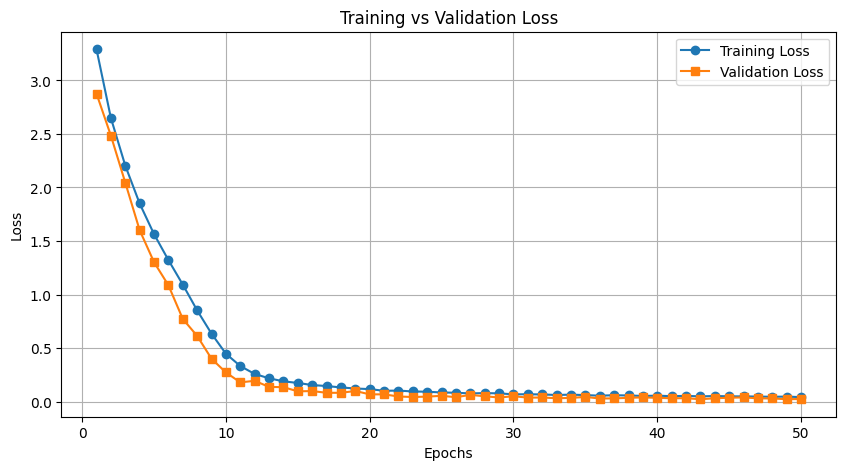

In [5]:
num_epochs = 50
patience = 10
best_model_path = "resnet18_best.pth"
best_val_loss = np.inf

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = ResNet18()
model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

# Lists to store loss values
train_losses = []
val_losses = []

try:
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")

        for batch_idx, (images, labels) in enumerate(progress_bar):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            progress_bar.set_postfix({
                'loss': f"{loss.item():.4f}",
                'avg_loss': f"{running_loss/(batch_idx+1):.4f}",
                'accuracy': f"{100 * correct / total:.2f}%"
            })

        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)
        epoch_accuracy = 100 * correct / total
        print(f"\nTraining - Epoch {epoch+1}: Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")

        # Validation
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_epoch_loss = val_loss / len(val_loader)
        val_losses.append(val_epoch_loss)
        val_epoch_accuracy = 100 * val_correct / val_total
        print(f"Validation - Epoch {epoch+1}: Loss: {val_epoch_loss:.4f}, Accuracy: {val_epoch_accuracy:.2f}%\n")

        # Check for improvement
        if val_epoch_loss < best_val_loss:
            best_val_loss = val_epoch_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), best_model_path)
            print(f"Validation loss improved. Model saved to {best_model_path}")
        else:
            epochs_no_improve += 1
            print(f"No improvement for {epochs_no_improve} epoch(s).")

        # Early stopping
        if epochs_no_improve >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs!")
            break

except KeyboardInterrupt:
    print("\nTraining interrupted by user.")
    # Optionally save latest model
    torch.save(model.state_dict(), "resnet18_interrupt.pth")
    print("Model saved after interrupt as 'resnet18_interrupt.pth'.")

finally:
    print("Training complete or interrupted.")
    # Plot losses
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label="Training Loss", marker='o')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss", marker='s')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.legend()
    plt.grid()
    plt.show()


Task A: ResNet18 DynamicConv

In [19]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.downsample = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )
            
    def forward(self, x):
        shortcut = self.downsample(x)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += shortcut
        out = self.relu(out)
        return out

class DynamicConv2d(nn.Module):
    def __init__(self, in_channels_max, out_channels, kernel_size, stride=1, padding=0):
        super(DynamicConv2d, self).__init__()
        self.in_channels_max = in_channels_max
        self.out_channels = out_channels
        self.kernel_size = kernel_size if isinstance(kernel_size, tuple) else (kernel_size, kernel_size)
        self.stride = stride
        self.padding = padding

        hidden_dim = 128
        self.weight_generator = nn.Sequential(
            nn.Linear(in_channels_max, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, out_channels * in_channels_max * self.kernel_size[0] * self.kernel_size[1])
        )

    def forward(self, x):
        batch_size, in_channels, H, W = x.size()
        input_mask = torch.zeros(self.in_channels_max, device=x.device)
        input_mask[:in_channels] = 1.0
        weight_vector = self.weight_generator(input_mask)
        weight = weight_vector.view(self.out_channels, self.in_channels_max, *self.kernel_size)
        weight = weight[:, :in_channels, :, :]
        return F.conv2d(x, weight, stride=self.stride, padding=self.padding)


class ResNet18_DynamicConv(nn.Module):
    def __init__(self, num_classes=50, in_channels_max=3):
        super(ResNet18_DynamicConv, self).__init__()
        self.in_channels = 64

        self.conv1 = DynamicConv2d(in_channels_max, 64, kernel_size=7, stride=2, padding=3) #DynamicConvLayer
        
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(BasicBlock, 64, 2, stride=1)
        self.layer2 = self._make_layer(BasicBlock, 128, 2, stride=2)
        self.layer3 = self._make_layer(BasicBlock, 256, 2, stride=2)
        self.layer4 = self._make_layer(BasicBlock, 512, 2, stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)
        
    def _make_layer(self, block, out_channels, num_blocks, stride):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels
        for _ in range(1, num_blocks):
            layers.append(block(out_channels, out_channels, stride=1))
        return nn.Sequential(*layers)
        
    def forward(self, x):
        x = self.conv1(x)  # dynamic conv layer
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


In [20]:
model = ResNet18_DynamicConv()
summary(model, input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet18_DynamicConv                     [1, 50]                   --
├─DynamicConv2d: 1-1                     [1, 64, 112, 112]         --
│    └─Sequential: 2-1                   [9408]                    --
│    │    └─Linear: 3-1                  [128]                     512
│    │    └─ReLU: 3-2                    [128]                     --
│    │    └─Linear: 3-3                  [9408]                    1,213,632
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         128
├─ReLU: 1-3                              [1, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [1, 64, 56, 56]           --
├─Sequential: 1-5                        [1, 64, 56, 56]           --
│    └─BasicBlock: 2-2                   [1, 64, 56, 56]           --
│    │    └─Sequential: 3-4              [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-5                  [1, 64, 56, 56]           36,864
│ 


=== Training with input channels: RGB (3) ===


Epoch 1/50: 100%|██████████| 1979/1979 [10:33<00:00,  3.12it/s, loss=3.1131, avg_loss=3.3308, accuracy=12.45%]


[Epoch 1] Validation Loss: 2.9727, Accuracy: 19.65%


Epoch 5/50: 100%|██████████| 1979/1979 [04:22<00:00,  7.53it/s, loss=1.5984, avg_loss=1.5200, accuracy=53.82%]


[Epoch 5] Validation Loss: 1.4951, Accuracy: 55.07%


Epoch 10/50: 100%|██████████| 1979/1979 [04:22<00:00,  7.55it/s, loss=0.7705, avg_loss=0.3732, accuracy=87.67%]


[Epoch 10] Validation Loss: 0.2095, Accuracy: 93.45%


Epoch 15/50: 100%|██████████| 1979/1979 [04:22<00:00,  7.55it/s, loss=0.0476, avg_loss=0.1614, accuracy=95.08%]


[Epoch 15] Validation Loss: 0.0956, Accuracy: 97.38%


Epoch 20/50: 100%|██████████| 1979/1979 [04:21<00:00,  7.56it/s, loss=0.2425, avg_loss=0.1097, accuracy=96.61%]


[Epoch 20] Validation Loss: 0.0690, Accuracy: 97.86%


Epoch 25/50: 100%|██████████| 1979/1979 [04:22<00:00,  7.54it/s, loss=0.1328, avg_loss=0.0864, accuracy=97.12%]


[Epoch 25] Validation Loss: 0.0525, Accuracy: 98.27%


Epoch 30/50: 100%|██████████| 1979/1979 [04:22<00:00,  7.55it/s, loss=0.2193, avg_loss=0.0710, accuracy=97.56%]


[Epoch 30] Validation Loss: 0.0418, Accuracy: 98.55%


Epoch 35/50: 100%|██████████| 1979/1979 [04:21<00:00,  7.56it/s, loss=0.2636, avg_loss=0.0560, accuracy=97.97%]


[Epoch 35] Validation Loss: 0.0280, Accuracy: 98.95%


Epoch 40/50: 100%|██████████| 1979/1979 [04:20<00:00,  7.58it/s, loss=0.0203, avg_loss=0.0536, accuracy=98.03%]


[Epoch 40] Validation Loss: 0.0350, Accuracy: 98.69%


Epoch 45/50: 100%|██████████| 1979/1979 [04:22<00:00,  7.53it/s, loss=0.0498, avg_loss=0.0484, accuracy=98.14%]


[Epoch 45] Validation Loss: 0.0261, Accuracy: 98.98%


Epoch 50/50: 100%|██████████| 1979/1979 [04:21<00:00,  7.57it/s, loss=0.0028, avg_loss=0.0432, accuracy=98.29%]


[Epoch 50] Validation Loss: 0.0295, Accuracy: 98.86%


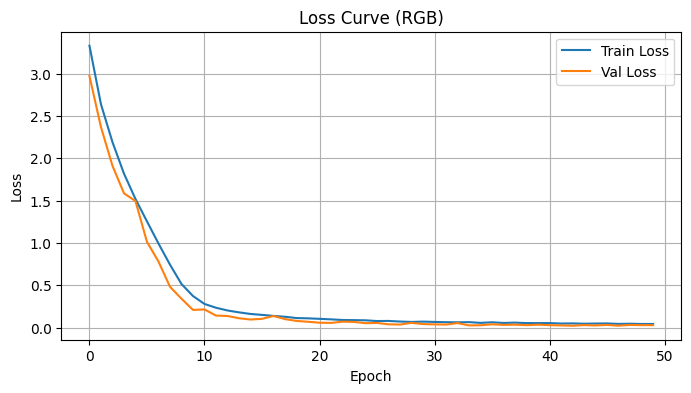


=== Training with input channels: RG (2) ===


Epoch 1/50: 100%|██████████| 1979/1979 [04:19<00:00,  7.64it/s, loss=2.7940, avg_loss=3.2844, accuracy=13.34%]


[Epoch 1] Validation Loss: 2.8591, Accuracy: 20.48%


Epoch 5/50: 100%|██████████| 1979/1979 [04:18<00:00,  7.66it/s, loss=1.8050, avg_loss=1.5601, accuracy=52.54%]


[Epoch 5] Validation Loss: 1.3744, Accuracy: 57.83%


Epoch 10/50: 100%|██████████| 1979/1979 [04:18<00:00,  7.64it/s, loss=0.2319, avg_loss=0.3575, accuracy=88.29%]


[Epoch 10] Validation Loss: 0.3566, Accuracy: 92.16%


Epoch 15/50: 100%|██████████| 1979/1979 [04:18<00:00,  7.64it/s, loss=0.4803, avg_loss=0.1607, accuracy=95.16%]


[Epoch 15] Validation Loss: 0.2659, Accuracy: 95.86%


Epoch 20/50: 100%|██████████| 1979/1979 [04:18<00:00,  7.64it/s, loss=0.0190, avg_loss=0.1133, accuracy=96.50%]


[Epoch 20] Validation Loss: 0.0691, Accuracy: 98.08%


Epoch 25/50: 100%|██████████| 1979/1979 [04:18<00:00,  7.67it/s, loss=0.0303, avg_loss=0.0836, accuracy=97.23%]


[Epoch 25] Validation Loss: 0.1018, Accuracy: 97.66%


Epoch 30/50: 100%|██████████| 1979/1979 [04:19<00:00,  7.63it/s, loss=0.1141, avg_loss=0.0663, accuracy=97.66%]


[Epoch 30] Validation Loss: 0.0705, Accuracy: 98.69%


Epoch 35/50: 100%|██████████| 1979/1979 [04:12<00:00,  7.83it/s, loss=0.0799, avg_loss=0.0578, accuracy=97.85%]


[Epoch 35] Validation Loss: 0.0577, Accuracy: 98.32%


Epoch 40/50: 100%|██████████| 1979/1979 [07:29<00:00,  4.41it/s, loss=0.0209, avg_loss=0.0524, accuracy=98.05%]


[Epoch 40] Validation Loss: 0.0357, Accuracy: 98.83%


Epoch 45/50: 100%|██████████| 1979/1979 [05:10<00:00,  6.38it/s, loss=0.0278, avg_loss=0.0464, accuracy=98.26%]


[Epoch 45] Validation Loss: 0.0260, Accuracy: 98.97%


Epoch 50/50: 100%|██████████| 1979/1979 [04:19<00:00,  7.62it/s, loss=0.1082, avg_loss=0.0439, accuracy=98.29%]


[Epoch 50] Validation Loss: 0.0297, Accuracy: 98.82%


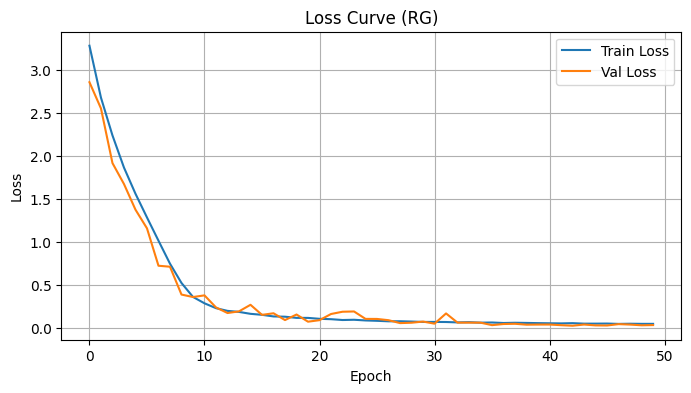


=== Training with input channels: GB (2) ===


Epoch 1/50: 100%|██████████| 1979/1979 [04:20<00:00,  7.59it/s, loss=3.1819, avg_loss=3.2660, accuracy=13.65%]


[Epoch 1] Validation Loss: 2.8704, Accuracy: 21.32%


Epoch 5/50: 100%|██████████| 1979/1979 [04:20<00:00,  7.61it/s, loss=1.5769, avg_loss=1.5616, accuracy=52.67%]


[Epoch 5] Validation Loss: 1.2569, Accuracy: 60.68%


Epoch 10/50: 100%|██████████| 1979/1979 [04:21<00:00,  7.57it/s, loss=0.5095, avg_loss=0.3618, accuracy=88.05%]


[Epoch 10] Validation Loss: 0.2719, Accuracy: 90.99%


Epoch 15/50: 100%|██████████| 1979/1979 [04:20<00:00,  7.58it/s, loss=0.3575, avg_loss=0.1633, accuracy=95.17%]


[Epoch 15] Validation Loss: 0.1175, Accuracy: 96.52%


Epoch 20/50: 100%|██████████| 1979/1979 [04:21<00:00,  7.58it/s, loss=0.0228, avg_loss=0.1110, accuracy=96.67%]


[Epoch 20] Validation Loss: 0.0571, Accuracy: 98.28%


Epoch 25/50: 100%|██████████| 1979/1979 [04:20<00:00,  7.58it/s, loss=0.0580, avg_loss=0.0819, accuracy=97.25%]


[Epoch 25] Validation Loss: 0.0445, Accuracy: 98.56%


Epoch 30/50: 100%|██████████| 1979/1979 [04:20<00:00,  7.58it/s, loss=0.0498, avg_loss=0.0670, accuracy=97.68%]


[Epoch 30] Validation Loss: 0.0841, Accuracy: 97.21%


Epoch 35/50: 100%|██████████| 1979/1979 [04:28<00:00,  7.36it/s, loss=0.0172, avg_loss=0.0559, accuracy=97.93%]


[Epoch 35] Validation Loss: 0.0378, Accuracy: 98.62%


Epoch 40/50: 100%|██████████| 1979/1979 [04:20<00:00,  7.59it/s, loss=0.0087, avg_loss=0.0499, accuracy=98.11%]


[Epoch 40] Validation Loss: 0.0365, Accuracy: 98.69%


Epoch 45/50: 100%|██████████| 1979/1979 [04:21<00:00,  7.58it/s, loss=0.1305, avg_loss=0.0473, accuracy=98.18%]


[Epoch 45] Validation Loss: 0.0275, Accuracy: 98.95%


Epoch 50/50: 100%|██████████| 1979/1979 [04:21<00:00,  7.58it/s, loss=0.0730, avg_loss=0.0445, accuracy=98.25%]


[Epoch 50] Validation Loss: 0.0238, Accuracy: 99.04%


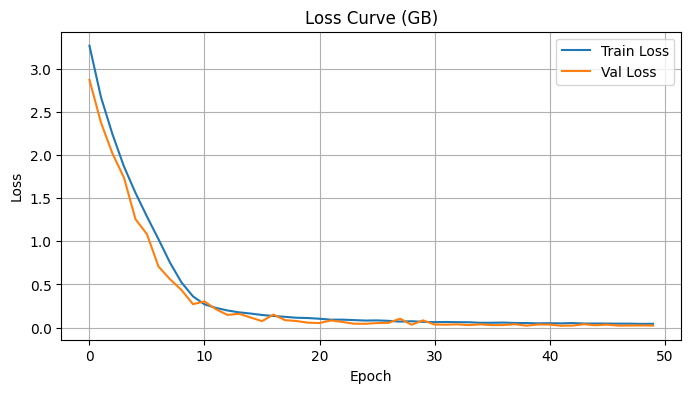


=== Training with input channels: RB (2) ===


Epoch 1/50: 100%|██████████| 1979/1979 [04:20<00:00,  7.61it/s, loss=2.9381, avg_loss=3.3065, accuracy=12.57%]


[Epoch 1] Validation Loss: 3.1392, Accuracy: 15.62%


Epoch 5/50: 100%|██████████| 1979/1979 [04:20<00:00,  7.60it/s, loss=1.8949, avg_loss=1.5632, accuracy=52.65%]


[Epoch 5] Validation Loss: 1.3943, Accuracy: 56.85%


Epoch 10/50: 100%|██████████| 1979/1979 [04:20<00:00,  7.61it/s, loss=0.1699, avg_loss=0.3700, accuracy=87.69%]


[Epoch 10] Validation Loss: 0.2254, Accuracy: 93.04%


Epoch 15/50: 100%|██████████| 1979/1979 [04:19<00:00,  7.63it/s, loss=0.1534, avg_loss=0.1596, accuracy=95.26%]


[Epoch 15] Validation Loss: 0.0973, Accuracy: 97.31%


Epoch 20/50: 100%|██████████| 1979/1979 [04:19<00:00,  7.61it/s, loss=0.1273, avg_loss=0.1079, accuracy=96.75%]


[Epoch 20] Validation Loss: 0.0654, Accuracy: 98.03%


Epoch 25/50: 100%|██████████| 1979/1979 [04:21<00:00,  7.57it/s, loss=0.1477, avg_loss=0.0859, accuracy=97.16%]


[Epoch 25] Validation Loss: 0.0592, Accuracy: 98.07%


Epoch 30/50: 100%|██████████| 1979/1979 [04:21<00:00,  7.58it/s, loss=0.0102, avg_loss=0.0657, accuracy=97.73%]


[Epoch 30] Validation Loss: 0.0506, Accuracy: 98.30%


Epoch 35/50: 100%|██████████| 1979/1979 [04:20<00:00,  7.59it/s, loss=0.2193, avg_loss=0.0603, accuracy=97.81%]


[Epoch 35] Validation Loss: 0.0353, Accuracy: 98.71%


Epoch 40/50: 100%|██████████| 1979/1979 [04:20<00:00,  7.59it/s, loss=0.0061, avg_loss=0.0522, accuracy=98.00%]


[Epoch 40] Validation Loss: 0.0329, Accuracy: 98.76%


Epoch 41/50: 100%|██████████| 1979/1979 [04:21<00:00,  7.58it/s, loss=0.1280, avg_loss=0.0513, accuracy=98.06%]


Early stopping at epoch 41 for RB


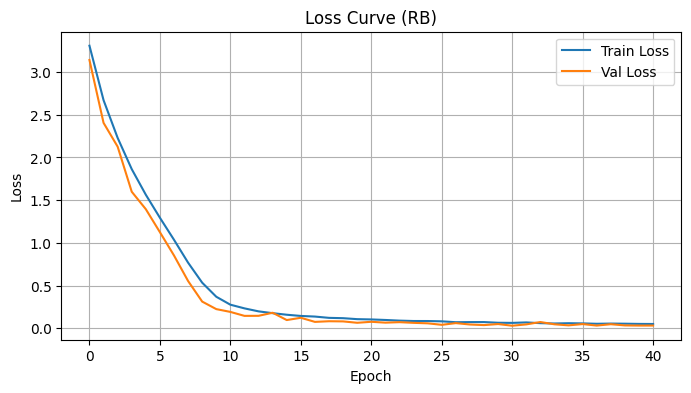


=== Training with input channels: R (1) ===


Epoch 1/50: 100%|██████████| 1979/1979 [04:12<00:00,  7.82it/s, loss=3.2621, avg_loss=3.4135, accuracy=10.81%]


[Epoch 1] Validation Loss: 3.2503, Accuracy: 12.88%


Epoch 5/50: 100%|██████████| 1979/1979 [04:12<00:00,  7.83it/s, loss=1.4752, avg_loss=1.7071, accuracy=48.78%]


[Epoch 5] Validation Loss: 1.4454, Accuracy: 55.92%


Epoch 10/50: 100%|██████████| 1979/1979 [04:13<00:00,  7.82it/s, loss=0.6997, avg_loss=0.3985, accuracy=86.58%]


[Epoch 10] Validation Loss: 0.2737, Accuracy: 91.08%


Epoch 15/50: 100%|██████████| 1979/1979 [04:12<00:00,  7.84it/s, loss=0.1784, avg_loss=0.1614, accuracy=95.30%]


[Epoch 15] Validation Loss: 0.1969, Accuracy: 94.04%


Epoch 20/50: 100%|██████████| 1979/1979 [04:12<00:00,  7.83it/s, loss=0.1125, avg_loss=0.1116, accuracy=96.61%]


[Epoch 20] Validation Loss: 0.0968, Accuracy: 97.08%


Epoch 25/50: 100%|██████████| 1979/1979 [04:12<00:00,  7.83it/s, loss=0.1699, avg_loss=0.0892, accuracy=97.10%]


[Epoch 25] Validation Loss: 0.0726, Accuracy: 97.56%


Epoch 30/50: 100%|██████████| 1979/1979 [04:12<00:00,  7.84it/s, loss=0.2213, avg_loss=0.0709, accuracy=97.53%]


[Epoch 30] Validation Loss: 0.0660, Accuracy: 97.78%


Epoch 35/50: 100%|██████████| 1979/1979 [04:13<00:00,  7.82it/s, loss=0.0049, avg_loss=0.0655, accuracy=97.68%]


[Epoch 35] Validation Loss: 0.0315, Accuracy: 98.86%


Epoch 40/50: 100%|██████████| 1979/1979 [04:12<00:00,  7.84it/s, loss=0.0196, avg_loss=0.0520, accuracy=98.11%]


[Epoch 40] Validation Loss: 0.0294, Accuracy: 98.89%


Epoch 45/50: 100%|██████████| 1979/1979 [04:12<00:00,  7.83it/s, loss=0.0063, avg_loss=0.0487, accuracy=98.13%]


[Epoch 45] Validation Loss: 0.0277, Accuracy: 98.95%


Epoch 50/50: 100%|██████████| 1979/1979 [04:11<00:00,  7.88it/s, loss=0.0086, avg_loss=0.0429, accuracy=98.32%]


[Epoch 50] Validation Loss: 0.0310, Accuracy: 98.79%


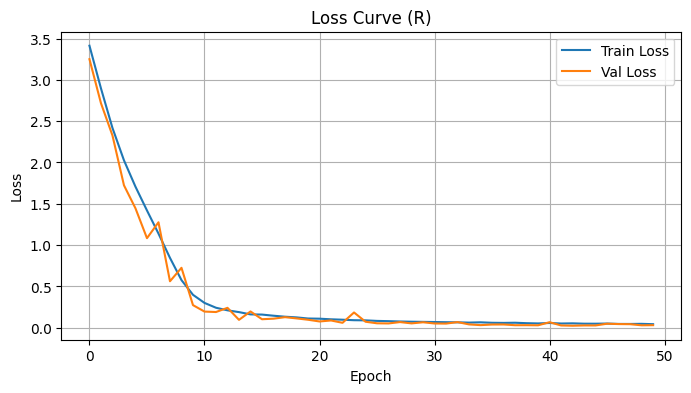


=== Training with input channels: G (1) ===


Epoch 1/50: 100%|██████████| 1979/1979 [04:13<00:00,  7.82it/s, loss=3.0986, avg_loss=3.3895, accuracy=11.12%]


[Epoch 1] Validation Loss: 3.4889, Accuracy: 11.69%


Epoch 5/50: 100%|██████████| 1979/1979 [04:13<00:00,  7.80it/s, loss=1.8940, avg_loss=1.6834, accuracy=49.31%]


[Epoch 5] Validation Loss: 1.7676, Accuracy: 48.80%


Epoch 10/50: 100%|██████████| 1979/1979 [04:14<00:00,  7.78it/s, loss=0.3903, avg_loss=0.4019, accuracy=86.56%]


[Epoch 10] Validation Loss: 0.3059, Accuracy: 90.08%


Epoch 15/50: 100%|██████████| 1979/1979 [04:14<00:00,  7.77it/s, loss=0.1068, avg_loss=0.1675, accuracy=95.05%]


[Epoch 15] Validation Loss: 0.1191, Accuracy: 96.59%


Epoch 20/50: 100%|██████████| 1979/1979 [04:14<00:00,  7.77it/s, loss=0.4097, avg_loss=0.1095, accuracy=96.66%]


[Epoch 20] Validation Loss: 0.0665, Accuracy: 97.96%


Epoch 25/50: 100%|██████████| 1979/1979 [04:14<00:00,  7.77it/s, loss=0.0804, avg_loss=0.0851, accuracy=97.16%]


[Epoch 25] Validation Loss: 0.0780, Accuracy: 97.43%


Epoch 30/50: 100%|██████████| 1979/1979 [04:14<00:00,  7.76it/s, loss=0.1501, avg_loss=0.0669, accuracy=97.69%]


[Epoch 30] Validation Loss: 0.0653, Accuracy: 97.78%


Epoch 35/50: 100%|██████████| 1979/1979 [04:14<00:00,  7.77it/s, loss=0.0485, avg_loss=0.0628, accuracy=97.77%]


[Epoch 35] Validation Loss: 0.0374, Accuracy: 98.68%


Epoch 40/50: 100%|██████████| 1979/1979 [04:14<00:00,  7.76it/s, loss=0.0862, avg_loss=0.0543, accuracy=98.00%]


[Epoch 40] Validation Loss: 0.0579, Accuracy: 97.99%


Epoch 45/50: 100%|██████████| 1979/1979 [04:18<00:00,  7.66it/s, loss=0.1215, avg_loss=0.0501, accuracy=98.07%]


[Epoch 45] Validation Loss: 0.0447, Accuracy: 98.36%


Epoch 50/50: 100%|██████████| 1979/1979 [04:17<00:00,  7.69it/s, loss=0.0612, avg_loss=0.0439, accuracy=98.27%]


[Epoch 50] Validation Loss: 0.0296, Accuracy: 98.92%


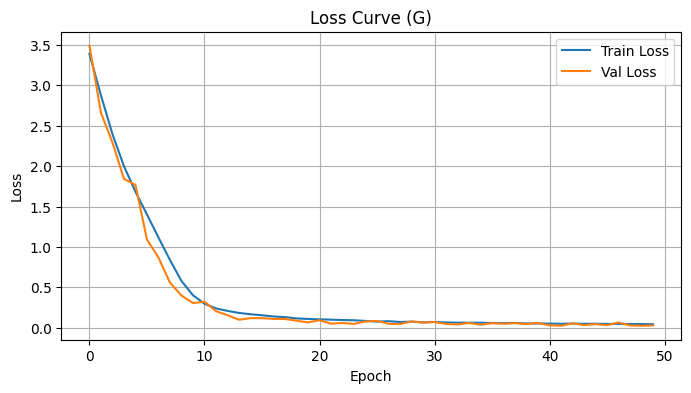


=== Training with input channels: B (1) ===


Epoch 1/50: 100%|██████████| 1979/1979 [04:16<00:00,  7.72it/s, loss=3.2351, avg_loss=3.3947, accuracy=11.03%]


[Epoch 1] Validation Loss: 3.1847, Accuracy: 13.86%


Epoch 5/50: 100%|██████████| 1979/1979 [04:16<00:00,  7.71it/s, loss=1.6984, avg_loss=1.6674, accuracy=49.58%]


[Epoch 5] Validation Loss: 1.4673, Accuracy: 55.18%


Epoch 10/50: 100%|██████████| 1979/1979 [04:17<00:00,  7.70it/s, loss=0.5018, avg_loss=0.3480, accuracy=88.52%]


[Epoch 10] Validation Loss: 0.2799, Accuracy: 90.90%


Epoch 15/50: 100%|██████████| 1979/1979 [04:16<00:00,  7.71it/s, loss=0.0281, avg_loss=0.1610, accuracy=95.28%]


[Epoch 15] Validation Loss: 0.0890, Accuracy: 97.55%


Epoch 20/50: 100%|██████████| 1979/1979 [04:17<00:00,  7.70it/s, loss=0.1652, avg_loss=0.1100, accuracy=96.56%]


[Epoch 20] Validation Loss: 0.0795, Accuracy: 97.53%


Epoch 25/50: 100%|██████████| 1979/1979 [04:17<00:00,  7.68it/s, loss=0.1000, avg_loss=0.0832, accuracy=97.21%]


[Epoch 25] Validation Loss: 0.0439, Accuracy: 98.54%


Epoch 30/50: 100%|██████████| 1979/1979 [04:17<00:00,  7.67it/s, loss=0.0851, avg_loss=0.0706, accuracy=97.61%]


[Epoch 30] Validation Loss: 0.0605, Accuracy: 97.98%


Epoch 35/50: 100%|██████████| 1979/1979 [04:17<00:00,  7.68it/s, loss=0.2346, avg_loss=0.0601, accuracy=97.79%]


[Epoch 35] Validation Loss: 0.0392, Accuracy: 98.66%


Epoch 40/50: 100%|██████████| 1979/1979 [04:16<00:00,  7.70it/s, loss=0.0708, avg_loss=0.0528, accuracy=98.05%]


[Epoch 40] Validation Loss: 0.0293, Accuracy: 98.90%


Epoch 45/50: 100%|██████████| 1979/1979 [04:17<00:00,  7.68it/s, loss=0.0257, avg_loss=0.0471, accuracy=98.16%]


[Epoch 45] Validation Loss: 0.0239, Accuracy: 99.04%


Epoch 50/50: 100%|██████████| 1979/1979 [04:17<00:00,  7.70it/s, loss=0.0266, avg_loss=0.0436, accuracy=98.34%]


[Epoch 50] Validation Loss: 0.0242, Accuracy: 99.02%


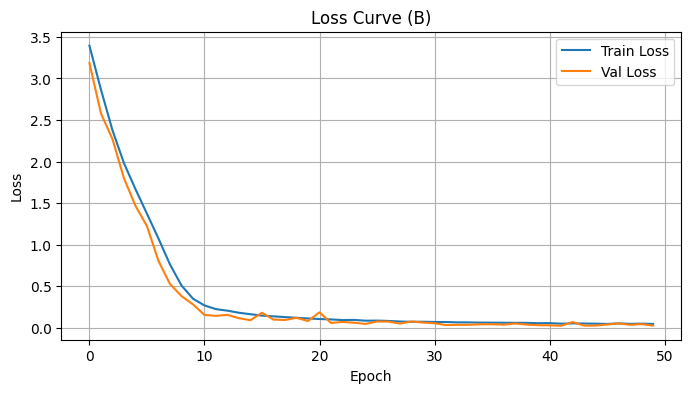


=== Summary of Results ===
Input Channels  Best Val Loss  Final Val Accuracy (%)
           RGB       0.022508                   98.86
            RG       0.022164                   98.82
            GB       0.022051                   99.04
            RB       0.031032                   98.77
             R       0.024303                   98.79
             G       0.025664                   98.92
             B       0.022559                   99.02


In [6]:
import signal


# Signal Handling
interrupted = False

def signal_handler(sig, frame):
    global interrupted
    print("\nKeyboardInterrupt received. Stopping training after current epoch...")
    interrupted = True

signal.signal(signal.SIGINT, signal_handler)

# Model, Criterion, Optimizer
model = ResNet18_DynamicConv(num_classes=50, in_channels_max=3).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
device = next(model.parameters()).device
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define channel settings
channel_settings = {
    'RGB': 3,
    'RG': 2,
    'GB': 2, 
    'RB': 2, 
    'R': 1,
    'G': 1,
    'B': 1
}

# Initialize results list to store summary data
results = []

# Loop over channel settings
for channel_name, in_channels in channel_settings.items():
    print(f"\n=== Training with input channels: {channel_name} ({in_channels}) ===")

    # Initialize model, optimizer, and other components
    model = ResNet18_DynamicConv(num_classes=50, in_channels_max=3).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
    device = next(model.parameters()).device
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    best_val_loss = np.inf
    patience = 10
    epochs_no_improve = 0
    num_epochs = 50
    train_losses = []
    val_losses = []

    interrupted = False  # Flag to track interruptions

    try:
        for epoch in range(num_epochs):
            model.train()
            running_loss = 0.0
            correct = 0
            total = 0

            progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")

            for batch_idx, (images, labels) in enumerate(progress_bar):
                # Ensure input channels match the current configuration
                if images.shape[1] > in_channels:
                    images = images[:, :in_channels, :, :]  # Trim channels if needed
                images, labels = images.to(device), labels.to(device)

                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                progress_bar.set_postfix({
                    'loss': f"{loss.item():.4f}",
                    'avg_loss': f"{running_loss/(batch_idx+1):.4f}",
                    'accuracy': f"{100 * correct / total:.2f}%"
                })

            epoch_loss = running_loss / len(train_loader)
            train_losses.append(epoch_loss)

            # Validation
            model.eval()
            val_loss = 0.0
            val_correct = 0
            val_total = 0

            with torch.no_grad():
                for images, labels in val_loader:
                    # Ensure input channels match the current configuration
                    if images.shape[1] > in_channels:
                        images = images[:, :in_channels, :, :]
                    images, labels = images.to(device), labels.to(device)

                    outputs = model(images)
                    loss = criterion(outputs, labels)

                    val_loss += loss.item()
                    _, predicted = torch.max(outputs.data, 1)
                    val_total += labels.size(0)
                    val_correct += (predicted == labels).sum().item()

            val_epoch_loss = val_loss / len(val_loader)
            val_losses.append(val_epoch_loss)

            if (epoch + 1) % 5 == 0 or epoch == 0:
                print(f"[Epoch {epoch+1}] Validation Loss: {val_epoch_loss:.4f}, Accuracy: {100 * val_correct / val_total:.2f}%")

            if val_epoch_loss < best_val_loss:
                best_val_loss = val_epoch_loss
                epochs_no_improve = 0
                torch.save(model.state_dict(), f"resnet18_best_{channel_name}.pth")
            else:
                epochs_no_improve += 1

            if epochs_no_improve >= patience:
                print(f"Early stopping at epoch {epoch+1} for {channel_name}")
                break

    except KeyboardInterrupt:
        print(f"\nTraining interrupted for {channel_name}. Saving the model so far...")
        interrupted = True

    results.append({
        'Input Channels': channel_name,
        'Best Val Loss': best_val_loss,
        'Final Val Accuracy (%)': round(100 * val_correct / val_total, 2)
    })

    # Plotting losses
    plt.figure(figsize=(8, 4))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.title(f'Loss Curve ({channel_name})')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

# === Summary Table ===
df = pd.DataFrame(results)
print("\n=== Summary of Results ===")
print(df.to_string(index=False))


ResNet34

In [21]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.downsample = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )
            
    def forward(self, x):
        shortcut = self.downsample(x)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += shortcut
        out = self.relu(out)
        return out

class ResNet34(nn.Module):
    def __init__(self, num_classes=50):
        super(ResNet34, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(BasicBlock, 64, 3, stride=1)
        self.layer2 = self._make_layer(BasicBlock, 128, 4, stride=2)
        self.layer3 = self._make_layer(BasicBlock, 256, 6, stride=2)
        self.layer4 = self._make_layer(BasicBlock, 512, 3, stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)
        
    def _make_layer(self, block, out_channels, num_blocks, stride):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels
        for _ in range(1, num_blocks):
            layers.append(block(out_channels, out_channels, stride=1))
        return nn.Sequential(*layers)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [22]:
model = ResNet34()
summary(model, input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet34                                 [1, 50]                   --
├─Conv2d: 1-1                            [1, 64, 112, 112]         9,408
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         128
├─ReLU: 1-3                              [1, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [1, 64, 56, 56]           --
├─Sequential: 1-5                        [1, 64, 56, 56]           --
│    └─BasicBlock: 2-1                   [1, 64, 56, 56]           --
│    │    └─Sequential: 3-1              [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-2                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-3             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-4                    [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-5                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-6             [1, 64, 56, 56]           128
│

Using device: cuda


Epoch 1/50: 100%|██████████| 1979/1979 [05:52<00:00,  5.61it/s, loss=2.8417, avg_loss=3.3207, accuracy=12.27%]



Training - Epoch 1: Loss: 3.3207, Accuracy: 12.27%
Validation - Epoch 1: Loss: 3.1115, Accuracy: 16.70%

Validation loss improved. Model saved to resnet34_best.pth


Epoch 2/50: 100%|██████████| 1979/1979 [05:52<00:00,  5.61it/s, loss=2.1994, avg_loss=2.7397, accuracy=23.49%]



Training - Epoch 2: Loss: 2.7397, Accuracy: 23.49%
Validation - Epoch 2: Loss: 2.5070, Accuracy: 29.42%

Validation loss improved. Model saved to resnet34_best.pth


Epoch 3/50: 100%|██████████| 1979/1979 [05:53<00:00,  5.60it/s, loss=2.2851, avg_loss=2.3093, accuracy=33.65%]



Training - Epoch 3: Loss: 2.3093, Accuracy: 33.65%
Validation - Epoch 3: Loss: 2.0387, Accuracy: 40.75%

Validation loss improved. Model saved to resnet34_best.pth


Epoch 4/50: 100%|██████████| 1979/1979 [05:52<00:00,  5.61it/s, loss=1.6886, avg_loss=1.9421, accuracy=42.79%]



Training - Epoch 4: Loss: 1.9421, Accuracy: 42.79%
Validation - Epoch 4: Loss: 1.7211, Accuracy: 48.19%

Validation loss improved. Model saved to resnet34_best.pth


Epoch 5/50: 100%|██████████| 1979/1979 [05:52<00:00,  5.61it/s, loss=2.0359, avg_loss=1.6279, accuracy=51.12%]



Training - Epoch 5: Loss: 1.6279, Accuracy: 51.12%
Validation - Epoch 5: Loss: 1.4243, Accuracy: 57.00%

Validation loss improved. Model saved to resnet34_best.pth


Epoch 6/50: 100%|██████████| 1979/1979 [05:52<00:00,  5.61it/s, loss=1.1832, avg_loss=1.3644, accuracy=57.87%]



Training - Epoch 6: Loss: 1.3644, Accuracy: 57.87%
Validation - Epoch 6: Loss: 1.1890, Accuracy: 63.92%

Validation loss improved. Model saved to resnet34_best.pth


Epoch 7/50: 100%|██████████| 1979/1979 [05:52<00:00,  5.61it/s, loss=1.2787, avg_loss=1.1112, accuracy=64.59%]



Training - Epoch 7: Loss: 1.1112, Accuracy: 64.59%
Validation - Epoch 7: Loss: 0.8978, Accuracy: 71.91%

Validation loss improved. Model saved to resnet34_best.pth


Epoch 8/50: 100%|██████████| 1979/1979 [05:52<00:00,  5.61it/s, loss=0.5022, avg_loss=0.8679, accuracy=71.73%]



Training - Epoch 8: Loss: 0.8679, Accuracy: 71.73%
Validation - Epoch 8: Loss: 0.6076, Accuracy: 81.12%

Validation loss improved. Model saved to resnet34_best.pth


Epoch 9/50: 100%|██████████| 1979/1979 [05:52<00:00,  5.61it/s, loss=0.7271, avg_loss=0.6305, accuracy=78.73%]



Training - Epoch 9: Loss: 0.6305, Accuracy: 78.73%
Validation - Epoch 9: Loss: 0.5398, Accuracy: 87.61%

Validation loss improved. Model saved to resnet34_best.pth


Epoch 10/50: 100%|██████████| 1979/1979 [05:53<00:00,  5.60it/s, loss=0.4045, avg_loss=0.4261, accuracy=85.48%]



Training - Epoch 10: Loss: 0.4261, Accuracy: 85.48%
Validation - Epoch 10: Loss: 0.3188, Accuracy: 91.85%

Validation loss improved. Model saved to resnet34_best.pth


Epoch 11/50: 100%|██████████| 1979/1979 [05:52<00:00,  5.61it/s, loss=0.2781, avg_loss=0.3306, accuracy=89.11%]



Training - Epoch 11: Loss: 0.3306, Accuracy: 89.11%
Validation - Epoch 11: Loss: 0.3588, Accuracy: 93.68%

No improvement for 1 epoch(s).


Epoch 12/50: 100%|██████████| 1979/1979 [05:52<00:00,  5.61it/s, loss=0.3436, avg_loss=0.2449, accuracy=92.18%]



Training - Epoch 12: Loss: 0.2449, Accuracy: 92.18%
Validation - Epoch 12: Loss: 0.5562, Accuracy: 93.73%

No improvement for 2 epoch(s).


Epoch 13/50: 100%|██████████| 1979/1979 [05:52<00:00,  5.61it/s, loss=0.5845, avg_loss=0.2207, accuracy=93.03%]



Training - Epoch 13: Loss: 0.2207, Accuracy: 93.03%
Validation - Epoch 13: Loss: 0.7378, Accuracy: 93.38%

No improvement for 3 epoch(s).


Epoch 14/50: 100%|██████████| 1979/1979 [05:52<00:00,  5.61it/s, loss=0.1148, avg_loss=0.1888, accuracy=94.22%]



Training - Epoch 14: Loss: 0.1888, Accuracy: 94.22%
Validation - Epoch 14: Loss: 0.2679, Accuracy: 94.37%

Validation loss improved. Model saved to resnet34_best.pth


Epoch 15/50: 100%|██████████| 1979/1979 [05:52<00:00,  5.61it/s, loss=0.8167, avg_loss=0.1743, accuracy=94.60%]



Training - Epoch 15: Loss: 0.1743, Accuracy: 94.60%
Validation - Epoch 15: Loss: 0.1464, Accuracy: 96.92%

Validation loss improved. Model saved to resnet34_best.pth


Epoch 16/50: 100%|██████████| 1979/1979 [05:52<00:00,  5.61it/s, loss=0.0996, avg_loss=0.1630, accuracy=94.93%]



Training - Epoch 16: Loss: 0.1630, Accuracy: 94.93%
Validation - Epoch 16: Loss: 0.1289, Accuracy: 96.75%

Validation loss improved. Model saved to resnet34_best.pth


Epoch 17/50: 100%|██████████| 1979/1979 [10:16<00:00,  3.21it/s, loss=0.1742, avg_loss=0.1379, accuracy=95.77%]



Training - Epoch 17: Loss: 0.1379, Accuracy: 95.77%
Validation - Epoch 17: Loss: 2.8866, Accuracy: 95.76%

No improvement for 1 epoch(s).


Epoch 18/50: 100%|██████████| 1979/1979 [05:52<00:00,  5.62it/s, loss=0.0749, avg_loss=0.1328, accuracy=95.91%]



Training - Epoch 18: Loss: 0.1328, Accuracy: 95.91%
Validation - Epoch 18: Loss: 0.8547, Accuracy: 97.26%

No improvement for 2 epoch(s).


Epoch 19/50: 100%|██████████| 1979/1979 [05:52<00:00,  5.62it/s, loss=0.1241, avg_loss=0.1194, accuracy=96.25%]



Training - Epoch 19: Loss: 0.1194, Accuracy: 96.25%
Validation - Epoch 19: Loss: 0.8933, Accuracy: 96.67%

No improvement for 3 epoch(s).


Epoch 20/50: 100%|██████████| 1979/1979 [05:52<00:00,  5.62it/s, loss=0.0289, avg_loss=0.1144, accuracy=96.30%]



Training - Epoch 20: Loss: 0.1144, Accuracy: 96.30%
Validation - Epoch 20: Loss: 0.1180, Accuracy: 98.19%

Validation loss improved. Model saved to resnet34_best.pth


Epoch 21/50: 100%|██████████| 1979/1979 [05:54<00:00,  5.58it/s, loss=0.1117, avg_loss=0.1053, accuracy=96.50%]



Training - Epoch 21: Loss: 0.1053, Accuracy: 96.50%
Validation - Epoch 21: Loss: 0.6725, Accuracy: 96.82%

No improvement for 1 epoch(s).


Epoch 22/50: 100%|██████████| 1979/1979 [06:19<00:00,  5.22it/s, loss=0.0867, avg_loss=0.1071, accuracy=96.48%]



Training - Epoch 22: Loss: 0.1071, Accuracy: 96.48%
Validation - Epoch 22: Loss: 0.6522, Accuracy: 97.34%

No improvement for 2 epoch(s).


Epoch 23/50: 100%|██████████| 1979/1979 [06:23<00:00,  5.15it/s, loss=0.2382, avg_loss=0.1000, accuracy=96.71%]



Training - Epoch 23: Loss: 0.1000, Accuracy: 96.71%
Validation - Epoch 23: Loss: 0.6579, Accuracy: 97.17%

No improvement for 3 epoch(s).


Epoch 24/50: 100%|██████████| 1979/1979 [05:57<00:00,  5.54it/s, loss=0.1194, avg_loss=0.0835, accuracy=97.17%]



Training - Epoch 24: Loss: 0.0835, Accuracy: 97.17%
Validation - Epoch 24: Loss: 2.0438, Accuracy: 96.68%

No improvement for 4 epoch(s).


Epoch 25/50: 100%|██████████| 1979/1979 [05:56<00:00,  5.55it/s, loss=0.1407, avg_loss=0.0967, accuracy=96.68%]



Training - Epoch 25: Loss: 0.0967, Accuracy: 96.68%
Validation - Epoch 25: Loss: 1.7132, Accuracy: 96.40%

No improvement for 5 epoch(s).


Epoch 26/50: 100%|██████████| 1979/1979 [05:55<00:00,  5.56it/s, loss=0.0238, avg_loss=0.0947, accuracy=96.81%]



Training - Epoch 26: Loss: 0.0947, Accuracy: 96.81%
Validation - Epoch 26: Loss: 1.7870, Accuracy: 96.59%

No improvement for 6 epoch(s).


Epoch 27/50: 100%|██████████| 1979/1979 [05:55<00:00,  5.57it/s, loss=0.0590, avg_loss=0.0785, accuracy=97.24%]



Training - Epoch 27: Loss: 0.0785, Accuracy: 97.24%
Validation - Epoch 27: Loss: 0.0473, Accuracy: 98.37%

Validation loss improved. Model saved to resnet34_best.pth


Epoch 28/50: 100%|██████████| 1979/1979 [05:56<00:00,  5.56it/s, loss=0.2006, avg_loss=0.0764, accuracy=97.32%]



Training - Epoch 28: Loss: 0.0764, Accuracy: 97.32%
Validation - Epoch 28: Loss: 0.0962, Accuracy: 97.55%

No improvement for 1 epoch(s).


Epoch 29/50: 100%|██████████| 1979/1979 [06:00<00:00,  5.49it/s, loss=0.1898, avg_loss=0.0731, accuracy=97.35%]



Training - Epoch 29: Loss: 0.0731, Accuracy: 97.35%
Validation - Epoch 29: Loss: 0.0344, Accuracy: 98.75%

Validation loss improved. Model saved to resnet34_best.pth


Epoch 30/50: 100%|██████████| 1979/1979 [05:56<00:00,  5.55it/s, loss=0.0904, avg_loss=0.0750, accuracy=97.34%]



Training - Epoch 30: Loss: 0.0750, Accuracy: 97.34%
Validation - Epoch 30: Loss: 0.0570, Accuracy: 98.25%

No improvement for 1 epoch(s).


Epoch 31/50: 100%|██████████| 1979/1979 [05:58<00:00,  5.52it/s, loss=0.0041, avg_loss=0.0677, accuracy=97.56%]



Training - Epoch 31: Loss: 0.0677, Accuracy: 97.56%
Validation - Epoch 31: Loss: 0.2734, Accuracy: 97.39%

No improvement for 2 epoch(s).


Epoch 32/50: 100%|██████████| 1979/1979 [05:57<00:00,  5.53it/s, loss=0.1204, avg_loss=0.0674, accuracy=97.58%]



Training - Epoch 32: Loss: 0.0674, Accuracy: 97.58%
Validation - Epoch 32: Loss: 0.1989, Accuracy: 97.71%

No improvement for 3 epoch(s).


Epoch 33/50: 100%|██████████| 1979/1979 [05:57<00:00,  5.54it/s, loss=0.0620, avg_loss=0.0647, accuracy=97.64%]



Training - Epoch 33: Loss: 0.0647, Accuracy: 97.64%
Validation - Epoch 33: Loss: 0.0412, Accuracy: 98.60%

No improvement for 4 epoch(s).


Epoch 34/50: 100%|██████████| 1979/1979 [05:56<00:00,  5.55it/s, loss=0.1314, avg_loss=0.0611, accuracy=97.75%]



Training - Epoch 34: Loss: 0.0611, Accuracy: 97.75%
Validation - Epoch 34: Loss: 0.1644, Accuracy: 97.81%

No improvement for 5 epoch(s).


Epoch 35/50: 100%|██████████| 1979/1979 [05:55<00:00,  5.56it/s, loss=0.0746, avg_loss=0.0587, accuracy=97.81%]



Training - Epoch 35: Loss: 0.0587, Accuracy: 97.81%
Validation - Epoch 35: Loss: 0.0430, Accuracy: 98.53%

No improvement for 6 epoch(s).


Epoch 36/50: 100%|██████████| 1979/1979 [05:56<00:00,  5.55it/s, loss=0.1082, avg_loss=0.0546, accuracy=97.93%]



Training - Epoch 36: Loss: 0.0546, Accuracy: 97.93%
Validation - Epoch 36: Loss: 0.0334, Accuracy: 98.77%

Validation loss improved. Model saved to resnet34_best.pth


Epoch 37/50: 100%|██████████| 1979/1979 [05:56<00:00,  5.55it/s, loss=0.0125, avg_loss=0.0601, accuracy=97.76%]



Training - Epoch 37: Loss: 0.0601, Accuracy: 97.76%
Validation - Epoch 37: Loss: 0.0512, Accuracy: 98.30%

No improvement for 1 epoch(s).


Epoch 38/50: 100%|██████████| 1979/1979 [05:55<00:00,  5.57it/s, loss=0.1525, avg_loss=0.0550, accuracy=97.94%]



Training - Epoch 38: Loss: 0.0550, Accuracy: 97.94%
Validation - Epoch 38: Loss: 0.0669, Accuracy: 98.34%

No improvement for 2 epoch(s).


Epoch 39/50: 100%|██████████| 1979/1979 [06:01<00:00,  5.48it/s, loss=0.0756, avg_loss=0.0578, accuracy=97.82%]



Training - Epoch 39: Loss: 0.0578, Accuracy: 97.82%
Validation - Epoch 39: Loss: 0.0364, Accuracy: 98.69%

No improvement for 3 epoch(s).


Epoch 40/50: 100%|██████████| 1979/1979 [05:57<00:00,  5.53it/s, loss=0.0458, avg_loss=0.0536, accuracy=98.01%]



Training - Epoch 40: Loss: 0.0536, Accuracy: 98.01%
Validation - Epoch 40: Loss: 0.0435, Accuracy: 98.43%

No improvement for 4 epoch(s).


Epoch 41/50: 100%|██████████| 1979/1979 [05:55<00:00,  5.56it/s, loss=0.1454, avg_loss=0.0531, accuracy=97.97%]



Training - Epoch 41: Loss: 0.0531, Accuracy: 97.97%
Validation - Epoch 41: Loss: 0.0387, Accuracy: 98.72%

No improvement for 5 epoch(s).


Epoch 42/50: 100%|██████████| 1979/1979 [05:55<00:00,  5.56it/s, loss=0.0174, avg_loss=0.0516, accuracy=98.11%]



Training - Epoch 42: Loss: 0.0516, Accuracy: 98.11%
Validation - Epoch 42: Loss: 0.0345, Accuracy: 98.74%

No improvement for 6 epoch(s).


Epoch 43/50: 100%|██████████| 1979/1979 [05:55<00:00,  5.57it/s, loss=0.0089, avg_loss=0.0501, accuracy=98.13%]



Training - Epoch 43: Loss: 0.0501, Accuracy: 98.13%
Validation - Epoch 43: Loss: 0.0476, Accuracy: 98.26%

No improvement for 7 epoch(s).


Epoch 44/50: 100%|██████████| 1979/1979 [06:05<00:00,  5.41it/s, loss=0.0581, avg_loss=0.0489, accuracy=98.07%]



Training - Epoch 44: Loss: 0.0489, Accuracy: 98.07%
Validation - Epoch 44: Loss: 0.0391, Accuracy: 98.67%

No improvement for 8 epoch(s).


Epoch 45/50: 100%|██████████| 1979/1979 [05:57<00:00,  5.53it/s, loss=0.0265, avg_loss=0.0478, accuracy=98.14%]



Training - Epoch 45: Loss: 0.0478, Accuracy: 98.14%
Validation - Epoch 45: Loss: 0.0647, Accuracy: 98.79%

No improvement for 9 epoch(s).


Epoch 46/50: 100%|██████████| 1979/1979 [05:55<00:00,  5.56it/s, loss=0.0305, avg_loss=0.0442, accuracy=98.27%]



Training - Epoch 46: Loss: 0.0442, Accuracy: 98.27%
Validation - Epoch 46: Loss: 0.0285, Accuracy: 98.95%

Validation loss improved. Model saved to resnet34_best.pth


Epoch 47/50: 100%|██████████| 1979/1979 [05:53<00:00,  5.60it/s, loss=0.0183, avg_loss=0.0478, accuracy=98.11%]



Training - Epoch 47: Loss: 0.0478, Accuracy: 98.11%
Validation - Epoch 47: Loss: 0.0373, Accuracy: 98.83%

No improvement for 1 epoch(s).


Epoch 48/50: 100%|██████████| 1979/1979 [05:50<00:00,  5.65it/s, loss=0.0347, avg_loss=0.0430, accuracy=98.30%]



Training - Epoch 48: Loss: 0.0430, Accuracy: 98.30%
Validation - Epoch 48: Loss: 0.0434, Accuracy: 98.53%

No improvement for 2 epoch(s).


Epoch 49/50: 100%|██████████| 1979/1979 [05:58<00:00,  5.52it/s, loss=0.0302, avg_loss=0.0466, accuracy=98.17%]



Training - Epoch 49: Loss: 0.0466, Accuracy: 98.17%
Validation - Epoch 49: Loss: 0.0263, Accuracy: 98.98%

Validation loss improved. Model saved to resnet34_best.pth


Epoch 50/50: 100%|██████████| 1979/1979 [06:02<00:00,  5.46it/s, loss=0.0101, avg_loss=0.0437, accuracy=98.29%]



Training - Epoch 50: Loss: 0.0437, Accuracy: 98.29%
Validation - Epoch 50: Loss: 0.2356, Accuracy: 98.32%

No improvement for 1 epoch(s).
Training complete or interrupted.


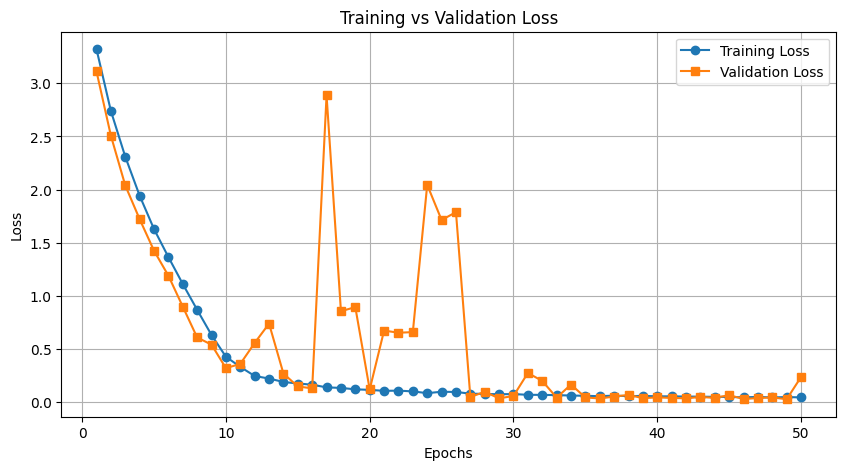

In [7]:
num_epochs = 50
patience = 10
best_model_path = "resnet34_best.pth"
best_val_loss = np.inf

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = ResNet34()
model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

# Lists to store loss values
train_losses = []
val_losses = []

try:
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")

        for batch_idx, (images, labels) in enumerate(progress_bar):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            progress_bar.set_postfix({
                'loss': f"{loss.item():.4f}",
                'avg_loss': f"{running_loss/(batch_idx+1):.4f}",
                'accuracy': f"{100 * correct / total:.2f}%"
            })

        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)
        epoch_accuracy = 100 * correct / total
        print(f"\nTraining - Epoch {epoch+1}: Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")

        # Validation
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_epoch_loss = val_loss / len(val_loader)
        val_losses.append(val_epoch_loss)
        val_epoch_accuracy = 100 * val_correct / val_total
        print(f"Validation - Epoch {epoch+1}: Loss: {val_epoch_loss:.4f}, Accuracy: {val_epoch_accuracy:.2f}%\n")

        # Check for improvement
        if val_epoch_loss < best_val_loss:
            best_val_loss = val_epoch_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), best_model_path)
            print(f"Validation loss improved. Model saved to {best_model_path}")
        else:
            epochs_no_improve += 1
            print(f"No improvement for {epochs_no_improve} epoch(s).")

        # Early stopping
        if epochs_no_improve >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs!")
            break

except KeyboardInterrupt:
    print("\nTraining interrupted by user.")
    # Optionally save latest model
    torch.save(model.state_dict(), "resnet34_interrupt.pth")
    print("Model saved after interrupt as 'resnet34_interrupt.pth'.")

finally:
    print("Training complete or interrupted.")
    # Plot losses
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label="Training Loss", marker='o')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss", marker='s')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.legend()
    plt.grid()
    plt.show()


myCNN

In [23]:
class myCNN(nn.Module):
    def __init__(self, num_classes=50):
        super(myCNN, self).__init__()

        # Layer 1
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(64)

        # Layer 2
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(128)

        # Layer 3
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(256)

        # Layer 4
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1)
        self.bn4 = nn.BatchNorm2d(512)

        # Classification head
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))  # Layer 1
        x = F.relu(self.bn2(self.conv2(x)))  # Layer 2
        x = F.relu(self.bn3(self.conv3(x)))  # Layer 3
        x = F.relu(self.bn4(self.conv4(x)))  # Layer 4
        x = self.global_pool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)
        return x


In [24]:
model = myCNN()
summary(model, input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
myCNN                                    [1, 50]                   --
├─Conv2d: 1-1                            [1, 64, 112, 112]         1,792
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         128
├─Conv2d: 1-3                            [1, 128, 56, 56]          73,856
├─BatchNorm2d: 1-4                       [1, 128, 56, 56]          256
├─Conv2d: 1-5                            [1, 256, 28, 28]          295,168
├─BatchNorm2d: 1-6                       [1, 256, 28, 28]          512
├─Conv2d: 1-7                            [1, 512, 14, 14]          1,180,160
├─BatchNorm2d: 1-8                       [1, 512, 14, 14]          1,024
├─AdaptiveAvgPool2d: 1-9                 [1, 512, 1, 1]            --
├─Dropout: 1-10                          [1, 512]                  --
├─Linear: 1-11                           [1, 50]                   25,650
Total params: 1,578,546
Trainable params: 1,578,546
Non-

Using device: cuda


Epoch 1/50: 100%|██████████| 1979/1979 [10:04<00:00,  3.27it/s, loss=3.3453, avg_loss=3.4543, accuracy=11.06%]



Training - Epoch 1: Loss: 3.4543, Accuracy: 11.06%
Validation - Epoch 1: Loss: 3.2430, Accuracy: 16.27%

Validation loss improved. Model saved to mycnn_best.pth


Epoch 2/50: 100%|██████████| 1979/1979 [03:09<00:00, 10.46it/s, loss=2.9390, avg_loss=3.0925, accuracy=18.09%]



Training - Epoch 2: Loss: 3.0925, Accuracy: 18.09%
Validation - Epoch 2: Loss: 2.8871, Accuracy: 23.06%

Validation loss improved. Model saved to mycnn_best.pth


Epoch 3/50: 100%|██████████| 1979/1979 [03:25<00:00,  9.61it/s, loss=2.6766, avg_loss=2.8141, accuracy=23.99%]



Training - Epoch 3: Loss: 2.8141, Accuracy: 23.99%
Validation - Epoch 3: Loss: 2.9386, Accuracy: 22.86%

No improvement for 1 epoch(s).


Epoch 4/50: 100%|██████████| 1979/1979 [03:20<00:00,  9.85it/s, loss=2.9937, avg_loss=2.6071, accuracy=28.32%]



Training - Epoch 4: Loss: 2.6071, Accuracy: 28.32%
Validation - Epoch 4: Loss: 2.4520, Accuracy: 32.85%

Validation loss improved. Model saved to mycnn_best.pth


Epoch 5/50: 100%|██████████| 1979/1979 [03:23<00:00,  9.70it/s, loss=2.6603, avg_loss=2.4478, accuracy=31.82%]



Training - Epoch 5: Loss: 2.4478, Accuracy: 31.82%
Validation - Epoch 5: Loss: 2.2231, Accuracy: 38.13%

Validation loss improved. Model saved to mycnn_best.pth


Epoch 6/50: 100%|██████████| 1979/1979 [03:26<00:00,  9.60it/s, loss=2.5689, avg_loss=2.3176, accuracy=34.59%]



Training - Epoch 6: Loss: 2.3176, Accuracy: 34.59%
Validation - Epoch 6: Loss: 2.1288, Accuracy: 39.59%

Validation loss improved. Model saved to mycnn_best.pth


Epoch 7/50: 100%|██████████| 1979/1979 [03:25<00:00,  9.63it/s, loss=3.0030, avg_loss=2.2088, accuracy=37.41%]



Training - Epoch 7: Loss: 2.2088, Accuracy: 37.41%
Validation - Epoch 7: Loss: 1.9902, Accuracy: 43.10%

Validation loss improved. Model saved to mycnn_best.pth


Epoch 8/50: 100%|██████████| 1979/1979 [03:29<00:00,  9.47it/s, loss=2.2065, avg_loss=2.1084, accuracy=39.75%]



Training - Epoch 8: Loss: 2.1084, Accuracy: 39.75%
Validation - Epoch 8: Loss: 1.9127, Accuracy: 45.32%

Validation loss improved. Model saved to mycnn_best.pth


Epoch 9/50: 100%|██████████| 1979/1979 [03:27<00:00,  9.54it/s, loss=2.1632, avg_loss=2.0181, accuracy=41.82%]



Training - Epoch 9: Loss: 2.0181, Accuracy: 41.82%
Validation - Epoch 9: Loss: 1.9931, Accuracy: 43.78%

No improvement for 1 epoch(s).


Epoch 10/50: 100%|██████████| 1979/1979 [03:17<00:00, 10.00it/s, loss=2.5865, avg_loss=1.9361, accuracy=43.95%]



Training - Epoch 10: Loss: 1.9361, Accuracy: 43.95%
Validation - Epoch 10: Loss: 1.7479, Accuracy: 50.11%

Validation loss improved. Model saved to mycnn_best.pth


Epoch 11/50: 100%|██████████| 1979/1979 [03:12<00:00, 10.29it/s, loss=1.4719, avg_loss=1.8608, accuracy=45.74%]



Training - Epoch 11: Loss: 1.8608, Accuracy: 45.74%
Validation - Epoch 11: Loss: 1.6310, Accuracy: 54.16%

Validation loss improved. Model saved to mycnn_best.pth


Epoch 12/50: 100%|██████████| 1979/1979 [03:12<00:00, 10.25it/s, loss=2.2746, avg_loss=1.7896, accuracy=47.61%]



Training - Epoch 12: Loss: 1.7896, Accuracy: 47.61%
Validation - Epoch 12: Loss: 1.5664, Accuracy: 55.18%

Validation loss improved. Model saved to mycnn_best.pth


Epoch 13/50: 100%|██████████| 1979/1979 [03:11<00:00, 10.32it/s, loss=1.7773, avg_loss=1.7204, accuracy=49.52%]



Training - Epoch 13: Loss: 1.7204, Accuracy: 49.52%
Validation - Epoch 13: Loss: 1.4620, Accuracy: 57.75%

Validation loss improved. Model saved to mycnn_best.pth


Epoch 14/50: 100%|██████████| 1979/1979 [03:19<00:00,  9.90it/s, loss=1.7226, avg_loss=1.6540, accuracy=51.03%]



Training - Epoch 14: Loss: 1.6540, Accuracy: 51.03%
Validation - Epoch 14: Loss: 1.3797, Accuracy: 59.04%

Validation loss improved. Model saved to mycnn_best.pth


Epoch 15/50: 100%|██████████| 1979/1979 [03:20<00:00,  9.86it/s, loss=1.3555, avg_loss=1.5886, accuracy=52.69%]



Training - Epoch 15: Loss: 1.5886, Accuracy: 52.69%
Validation - Epoch 15: Loss: 1.3159, Accuracy: 61.50%

Validation loss improved. Model saved to mycnn_best.pth


Epoch 16/50: 100%|██████████| 1979/1979 [03:21<00:00,  9.82it/s, loss=1.4285, avg_loss=1.5261, accuracy=54.26%]



Training - Epoch 16: Loss: 1.5261, Accuracy: 54.26%
Validation - Epoch 16: Loss: 1.3843, Accuracy: 57.77%

No improvement for 1 epoch(s).


Epoch 17/50: 100%|██████████| 1979/1979 [03:20<00:00,  9.85it/s, loss=1.5751, avg_loss=1.4723, accuracy=55.74%]



Training - Epoch 17: Loss: 1.4723, Accuracy: 55.74%
Validation - Epoch 17: Loss: 1.2133, Accuracy: 64.53%

Validation loss improved. Model saved to mycnn_best.pth


Epoch 18/50: 100%|██████████| 1979/1979 [03:20<00:00,  9.89it/s, loss=1.0518, avg_loss=1.4134, accuracy=56.91%]



Training - Epoch 18: Loss: 1.4134, Accuracy: 56.91%
Validation - Epoch 18: Loss: 1.2056, Accuracy: 64.87%

Validation loss improved. Model saved to mycnn_best.pth


Epoch 19/50: 100%|██████████| 1979/1979 [03:13<00:00, 10.21it/s, loss=1.5662, avg_loss=1.3631, accuracy=58.19%]



Training - Epoch 19: Loss: 1.3631, Accuracy: 58.19%
Validation - Epoch 19: Loss: 1.0678, Accuracy: 67.75%

Validation loss improved. Model saved to mycnn_best.pth


Epoch 20/50: 100%|██████████| 1979/1979 [03:10<00:00, 10.40it/s, loss=1.5064, avg_loss=1.3034, accuracy=59.79%]



Training - Epoch 20: Loss: 1.3034, Accuracy: 59.79%
Validation - Epoch 20: Loss: 1.0446, Accuracy: 69.60%

Validation loss improved. Model saved to mycnn_best.pth


Epoch 21/50: 100%|██████████| 1979/1979 [03:13<00:00, 10.25it/s, loss=1.8909, avg_loss=1.2590, accuracy=61.12%]



Training - Epoch 21: Loss: 1.2590, Accuracy: 61.12%
Validation - Epoch 21: Loss: 0.9628, Accuracy: 72.45%

Validation loss improved. Model saved to mycnn_best.pth


Epoch 22/50: 100%|██████████| 1979/1979 [03:29<00:00,  9.44it/s, loss=1.1736, avg_loss=1.2118, accuracy=62.58%]



Training - Epoch 22: Loss: 1.2118, Accuracy: 62.58%
Validation - Epoch 22: Loss: 0.9134, Accuracy: 72.99%

Validation loss improved. Model saved to mycnn_best.pth


Epoch 23/50: 100%|██████████| 1979/1979 [03:31<00:00,  9.34it/s, loss=0.8919, avg_loss=1.1690, accuracy=63.50%]



Training - Epoch 23: Loss: 1.1690, Accuracy: 63.50%
Validation - Epoch 23: Loss: 0.8980, Accuracy: 73.47%

Validation loss improved. Model saved to mycnn_best.pth


Epoch 24/50: 100%|██████████| 1979/1979 [03:17<00:00, 10.02it/s, loss=1.5351, avg_loss=1.1220, accuracy=64.80%]



Training - Epoch 24: Loss: 1.1220, Accuracy: 64.80%
Validation - Epoch 24: Loss: 0.8524, Accuracy: 75.19%

Validation loss improved. Model saved to mycnn_best.pth


Epoch 25/50: 100%|██████████| 1979/1979 [03:22<00:00,  9.76it/s, loss=1.2689, avg_loss=1.0831, accuracy=65.95%]



Training - Epoch 25: Loss: 1.0831, Accuracy: 65.95%
Validation - Epoch 25: Loss: 0.7606, Accuracy: 77.90%

Validation loss improved. Model saved to mycnn_best.pth


Epoch 26/50: 100%|██████████| 1979/1979 [03:31<00:00,  9.34it/s, loss=1.0065, avg_loss=1.0404, accuracy=67.11%]



Training - Epoch 26: Loss: 1.0404, Accuracy: 67.11%
Validation - Epoch 26: Loss: 0.6989, Accuracy: 80.99%

Validation loss improved. Model saved to mycnn_best.pth


Epoch 27/50: 100%|██████████| 1979/1979 [03:17<00:00, 10.03it/s, loss=0.6257, avg_loss=1.0044, accuracy=68.16%]



Training - Epoch 27: Loss: 1.0044, Accuracy: 68.16%
Validation - Epoch 27: Loss: 0.8567, Accuracy: 74.89%

No improvement for 1 epoch(s).


Epoch 28/50: 100%|██████████| 1979/1979 [03:18<00:00,  9.95it/s, loss=0.9549, avg_loss=0.9621, accuracy=69.61%]



Training - Epoch 28: Loss: 0.9621, Accuracy: 69.61%
Validation - Epoch 28: Loss: 0.6432, Accuracy: 81.80%

Validation loss improved. Model saved to mycnn_best.pth


Epoch 29/50: 100%|██████████| 1979/1979 [03:19<00:00,  9.91it/s, loss=0.9506, avg_loss=0.9345, accuracy=70.35%]



Training - Epoch 29: Loss: 0.9345, Accuracy: 70.35%
Validation - Epoch 29: Loss: 0.6612, Accuracy: 80.53%

No improvement for 1 epoch(s).


Epoch 30/50: 100%|██████████| 1979/1979 [03:22<00:00,  9.78it/s, loss=1.2272, avg_loss=0.8989, accuracy=71.42%]



Training - Epoch 30: Loss: 0.8989, Accuracy: 71.42%
Validation - Epoch 30: Loss: 0.6112, Accuracy: 83.08%

Validation loss improved. Model saved to mycnn_best.pth


Epoch 31/50: 100%|██████████| 1979/1979 [03:12<00:00, 10.28it/s, loss=1.0454, avg_loss=0.8659, accuracy=72.49%]



Training - Epoch 31: Loss: 0.8659, Accuracy: 72.49%
Validation - Epoch 31: Loss: 0.5533, Accuracy: 85.13%

Validation loss improved. Model saved to mycnn_best.pth


Epoch 32/50: 100%|██████████| 1979/1979 [03:20<00:00,  9.85it/s, loss=0.8747, avg_loss=0.8364, accuracy=73.26%]



Training - Epoch 32: Loss: 0.8364, Accuracy: 73.26%
Validation - Epoch 32: Loss: 0.5371, Accuracy: 85.98%

Validation loss improved. Model saved to mycnn_best.pth


Epoch 33/50: 100%|██████████| 1979/1979 [03:13<00:00, 10.22it/s, loss=0.5112, avg_loss=0.8114, accuracy=74.17%]



Training - Epoch 33: Loss: 0.8114, Accuracy: 74.17%
Validation - Epoch 33: Loss: 0.4909, Accuracy: 86.06%

Validation loss improved. Model saved to mycnn_best.pth


Epoch 34/50: 100%|██████████| 1979/1979 [03:13<00:00, 10.24it/s, loss=0.8146, avg_loss=0.7811, accuracy=75.24%]



Training - Epoch 34: Loss: 0.7811, Accuracy: 75.24%
Validation - Epoch 34: Loss: 0.4498, Accuracy: 88.49%

Validation loss improved. Model saved to mycnn_best.pth


Epoch 35/50: 100%|██████████| 1979/1979 [03:12<00:00, 10.28it/s, loss=0.8742, avg_loss=0.7532, accuracy=76.00%]



Training - Epoch 35: Loss: 0.7532, Accuracy: 76.00%
Validation - Epoch 35: Loss: 0.4388, Accuracy: 88.16%

Validation loss improved. Model saved to mycnn_best.pth


Epoch 36/50: 100%|██████████| 1979/1979 [03:13<00:00, 10.25it/s, loss=0.6161, avg_loss=0.7259, accuracy=76.84%]



Training - Epoch 36: Loss: 0.7259, Accuracy: 76.84%
Validation - Epoch 36: Loss: 0.4169, Accuracy: 89.49%

Validation loss improved. Model saved to mycnn_best.pth


Epoch 37/50: 100%|██████████| 1979/1979 [03:10<00:00, 10.41it/s, loss=0.6981, avg_loss=0.6993, accuracy=77.72%]



Training - Epoch 37: Loss: 0.6993, Accuracy: 77.72%
Validation - Epoch 37: Loss: 0.4348, Accuracy: 88.48%

No improvement for 1 epoch(s).


Epoch 38/50: 100%|██████████| 1979/1979 [03:16<00:00, 10.09it/s, loss=0.8666, avg_loss=0.6865, accuracy=78.28%]



Training - Epoch 38: Loss: 0.6865, Accuracy: 78.28%
Validation - Epoch 38: Loss: 0.3750, Accuracy: 90.33%

Validation loss improved. Model saved to mycnn_best.pth


Epoch 39/50: 100%|██████████| 1979/1979 [03:12<00:00, 10.30it/s, loss=0.5460, avg_loss=0.6632, accuracy=78.83%]



Training - Epoch 39: Loss: 0.6632, Accuracy: 78.83%
Validation - Epoch 39: Loss: 0.3909, Accuracy: 90.94%

No improvement for 1 epoch(s).


Epoch 40/50: 100%|██████████| 1979/1979 [03:11<00:00, 10.32it/s, loss=0.5707, avg_loss=0.6451, accuracy=79.20%]



Training - Epoch 40: Loss: 0.6451, Accuracy: 79.20%
Validation - Epoch 40: Loss: 0.3824, Accuracy: 90.64%

No improvement for 2 epoch(s).


Epoch 41/50: 100%|██████████| 1979/1979 [03:11<00:00, 10.33it/s, loss=0.3958, avg_loss=0.6204, accuracy=80.64%]



Training - Epoch 41: Loss: 0.6204, Accuracy: 80.64%
Validation - Epoch 41: Loss: 0.3493, Accuracy: 91.82%

Validation loss improved. Model saved to mycnn_best.pth


Epoch 42/50: 100%|██████████| 1979/1979 [03:11<00:00, 10.34it/s, loss=0.7066, avg_loss=0.6025, accuracy=80.91%]



Training - Epoch 42: Loss: 0.6025, Accuracy: 80.91%
Validation - Epoch 42: Loss: 0.3706, Accuracy: 90.57%

No improvement for 1 epoch(s).


Epoch 43/50: 100%|██████████| 1979/1979 [03:11<00:00, 10.34it/s, loss=0.3851, avg_loss=0.5846, accuracy=81.55%]



Training - Epoch 43: Loss: 0.5846, Accuracy: 81.55%
Validation - Epoch 43: Loss: 0.3126, Accuracy: 91.93%

Validation loss improved. Model saved to mycnn_best.pth


Epoch 44/50: 100%|██████████| 1979/1979 [03:13<00:00, 10.23it/s, loss=0.4350, avg_loss=0.5722, accuracy=82.02%]



Training - Epoch 44: Loss: 0.5722, Accuracy: 82.02%
Validation - Epoch 44: Loss: 0.3475, Accuracy: 92.76%

No improvement for 1 epoch(s).


Epoch 45/50: 100%|██████████| 1979/1979 [03:12<00:00, 10.27it/s, loss=0.5047, avg_loss=0.5560, accuracy=82.68%]



Training - Epoch 45: Loss: 0.5560, Accuracy: 82.68%
Validation - Epoch 45: Loss: 0.2830, Accuracy: 94.05%

Validation loss improved. Model saved to mycnn_best.pth


Epoch 46/50: 100%|██████████| 1979/1979 [03:12<00:00, 10.28it/s, loss=0.5411, avg_loss=0.5401, accuracy=83.16%]



Training - Epoch 46: Loss: 0.5401, Accuracy: 83.16%
Validation - Epoch 46: Loss: 0.3002, Accuracy: 93.72%

No improvement for 1 epoch(s).


Epoch 47/50: 100%|██████████| 1979/1979 [03:13<00:00, 10.25it/s, loss=0.3534, avg_loss=0.5200, accuracy=83.95%]



Training - Epoch 47: Loss: 0.5200, Accuracy: 83.95%
Validation - Epoch 47: Loss: 0.2373, Accuracy: 95.41%

Validation loss improved. Model saved to mycnn_best.pth


Epoch 48/50: 100%|██████████| 1979/1979 [03:10<00:00, 10.36it/s, loss=0.5602, avg_loss=0.5119, accuracy=84.06%]



Training - Epoch 48: Loss: 0.5119, Accuracy: 84.06%
Validation - Epoch 48: Loss: 0.2641, Accuracy: 94.06%

No improvement for 1 epoch(s).


Epoch 49/50: 100%|██████████| 1979/1979 [03:11<00:00, 10.33it/s, loss=0.3656, avg_loss=0.4967, accuracy=84.59%]



Training - Epoch 49: Loss: 0.4967, Accuracy: 84.59%
Validation - Epoch 49: Loss: 0.2119, Accuracy: 95.94%

Validation loss improved. Model saved to mycnn_best.pth


Epoch 50/50: 100%|██████████| 1979/1979 [03:14<00:00, 10.15it/s, loss=0.3999, avg_loss=0.4783, accuracy=85.26%]



Training - Epoch 50: Loss: 0.4783, Accuracy: 85.26%
Validation - Epoch 50: Loss: 0.1961, Accuracy: 96.55%

Validation loss improved. Model saved to mycnn_best.pth
Training complete or interrupted.


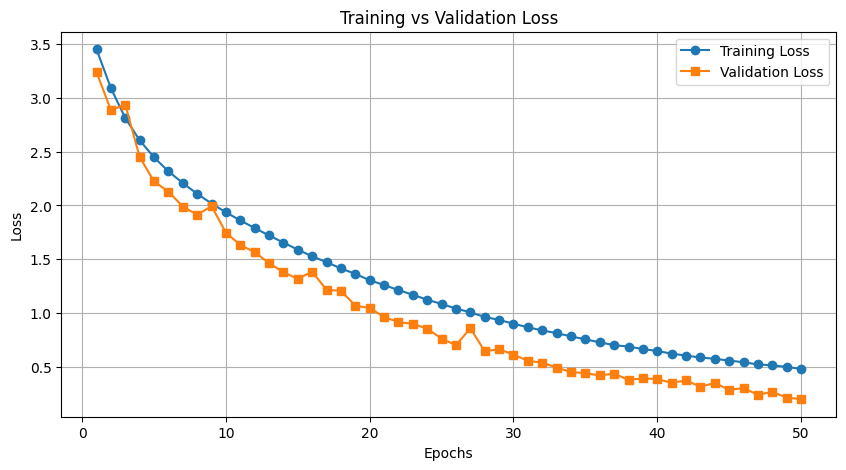

In [22]:
num_epochs = 50
patience = 10
best_model_path = "mycnn_best.pth"
best_val_loss = np.inf

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = myCNN()
model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

# Lists to store loss values
train_losses = []
val_losses = []

try:
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")

        for batch_idx, (images, labels) in enumerate(progress_bar):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            progress_bar.set_postfix({
                'loss': f"{loss.item():.4f}",
                'avg_loss': f"{running_loss/(batch_idx+1):.4f}",
                'accuracy': f"{100 * correct / total:.2f}%"
            })

        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)
        epoch_accuracy = 100 * correct / total
        print(f"\nTraining - Epoch {epoch+1}: Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")

        # Validation
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_epoch_loss = val_loss / len(val_loader)
        val_losses.append(val_epoch_loss)
        val_epoch_accuracy = 100 * val_correct / val_total
        print(f"Validation - Epoch {epoch+1}: Loss: {val_epoch_loss:.4f}, Accuracy: {val_epoch_accuracy:.2f}%\n")

        # Check for improvement
        if val_epoch_loss < best_val_loss:
            best_val_loss = val_epoch_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), best_model_path)
            print(f"Validation loss improved. Model saved to {best_model_path}")
        else:
            epochs_no_improve += 1
            print(f"No improvement for {epochs_no_improve} epoch(s).")

        # Early stopping
        if epochs_no_improve >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs!")
            break

except KeyboardInterrupt:
    print("\nTraining interrupted by user.")
    # Optionally save latest model
    torch.save(model.state_dict(), "mycnn_interrupt.pth")
    print("Model saved after interrupt as 'mycnn_interrupt.pth'.")

finally:
    print("Training complete or interrupted.")
    # Plot losses
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label="Training Loss", marker='o')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss", marker='s')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.legend()
    plt.grid()
    plt.show()


In [2]:
# ablation study, remove one layer
class myCNN(nn.Module):
    def __init__(self, num_classes=50):
        super(myCNN, self).__init__()

        # Layer 1
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(64)

        # Layer 2
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(128)

        # Layer 3
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(256)

        # Classification head
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))  # Layer 1
        x = F.relu(self.bn2(self.conv2(x)))  # Layer 2
        x = F.relu(self.bn3(self.conv3(x)))  # Layer 3
        x = self.global_pool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)
        return x


NameError: name 'nn' is not defined

In [ ]:
# ablation study, remove one layer
num_epochs = 50
patience = 10
best_model_path = "mycnn_best.pth"
best_val_loss = np.inf

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = myCNN()
model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

# Lists to store loss values
train_losses = []
val_losses = []

try:
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")

        for batch_idx, (images, labels) in enumerate(progress_bar):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            progress_bar.set_postfix({
                'loss': f"{loss.item():.4f}",
                'avg_loss': f"{running_loss/(batch_idx+1):.4f}",
                'accuracy': f"{100 * correct / total:.2f}%"
            })

        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)
        epoch_accuracy = 100 * correct / total
        print(f"\nTraining - Epoch {epoch+1}: Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")

        # Validation
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_epoch_loss = val_loss / len(val_loader)
        val_losses.append(val_epoch_loss)
        val_epoch_accuracy = 100 * val_correct / val_total
        print(f"Validation - Epoch {epoch+1}: Loss: {val_epoch_loss:.4f}, Accuracy: {val_epoch_accuracy:.2f}%\n")

        # Check for improvement
        if val_epoch_loss < best_val_loss:
            best_val_loss = val_epoch_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), best_model_path)
            print(f"Validation loss improved. Model saved to {best_model_path}")
        else:
            epochs_no_improve += 1
            print(f"No improvement for {epochs_no_improve} epoch(s).")

        # Early stopping
        if epochs_no_improve >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs!")
            break

except KeyboardInterrupt:
    print("\nTraining interrupted by user.")
    # Optionally save latest model
    torch.save(model.state_dict(), "mycnn_interrupt.pth")
    print("Model saved after interrupt as 'mycnn_interrupt.pth'.")

finally:
    print("Training complete or interrupted.")
    # Plot losses
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label="Training Loss", marker='o')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss", marker='s')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.legend()
    plt.grid()
    plt.show()
